#FLIM ANALYSIS SCRIPT#
The main function of this application is **identifying and characterising** lifetime signals.





#FLIM ANALYSIS FUNCTIONS#

##DECODING FUNCTION AND RAW DATA MANAGEMENT
Raw data management and decoding functions are necessary to access data and make it simple to use:
- **sizeR64**: determines the size of the R64 compressed file
- **decodeR64**: decodes R64 file into actionable data
- **dataset_list**: determines lists of datasets given as input to group replicates
- **datastitch**: generates stitched images of intensity, phase and module




In [ ]:
import struct
import zlib
import numpy as np
import re
import glob

def dataset_list(analysis):
	R64_list=glob.glob('*.R64', recursive=True)
	if analysis=='cumulative':
		res = (re.findall(r'\_(.*?)\_', (str(R64_list))))
		R64_lists=list(set(res))
	elif analysis == 'single file':
		R64_lists=R64_list
	return R64_lists

def refdataset_list(analysis):
	R64_list=glob.glob('*.ref', recursive=True)
	if analysis=='cumulative':
		res = (re.findall(r'\_(.*?)\_', (str(R64_list))))
		R64_lists=list(set(res))
	elif analysis == 'single file':
		R64_lists=R64_list
	return R64_lists

#function to determine R64 size
def sizeR64(R64ref):
  #Im_size is a tuple, one must extract the int32 value at position [0]
	Im_size = struct.unpack('<i', zlib.decompressobj().decompress(R64ref, 4))[0]
	return Im_size

#function to decode R64
def decodeR64(R64ref):
	Im_size=sizeR64(R64ref[0:256])
	cell_size=5*Im_size*Im_size
	dp=np.dtype('<f4')
	bufsize = cell_size * dp.itemsize + 4
	data_raw = zlib.decompress(R64ref, bufsize=bufsize)
	data_raw = np.frombuffer(data_raw, '<' + dp.char, offset=4)
	data_raw = data_raw[: cell_size].copy()
	data_raw = np.reshape(data_raw, (-1, Im_size, Im_size))
	data_raw[0,:,:] = data_raw[0,:,:] / np.amax(data_raw[0,:,:])
	return data_raw

def decode_ref(R64ref):
	Im_size=256
	cell_size=5*Im_size*Im_size
	dp=np.dtype('<f4')
	data_raw=np.frombuffer(R64ref, dtype=dp)
	data_raw = data_raw[: cell_size].copy()
	data_raw = np.reshape(data_raw, (-1, Im_size, Im_size))
	data_raw[0,:,:] = data_raw[0,:,:] / np.amax(data_raw[0,:,:])
	return data_raw


def datastitch(datalist,file_ext):
	first = True
	for R64_file in datalist:
		if first == True:
      #generate larger image of fixed width 512px and height n*512
			with open(R64_file, 'rb') as file: # b is important -> binary
				fileContent = file.read()
			if file_ext == 'R64':
				datalayer = decodeR64(fileContent)
			elif file_ext == 'ref':
				datalayer = decode_ref(fileContent)
		if first == False:
			with open(R64_file, 'rb') as file: # b is important -> binary
				fileContent = file.read()
			if file_ext == 'R64':
				additional_datalayer = decodeR64(fileContent)
			elif file_ext == 'ref':
				additional_datalayer = decode_ref(fileContent)
			datalayer = np.concatenate((datalayer, additional_datalayer),axis=1)
		first = False
	return datalayer



##MASKING

In [ ]:
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from skimage import data, img_as_float,color, img_as_ubyte
from skimage.io import imread
from skimage import color, io
from skimage.filters import threshold_multiotsu
import scipy
import numpy as np
import glob
from skimage.measure import label, regionprops, regionprops_table


#function to decode tiff
def decodeTiff(tif_item,mode):
  img = imread(tif_item)
  img_ch1 = img[:,:,2] #CANALE DELLA TRESHOLD SPOT
  img_ch0 = img[:,:,0] #CANALE DELLA TRESHOLD SHG
  thr_ch1 = threshold_multiotsu(image= img_ch1,classes=3)
  binary_spot = img_ch1 > thr_ch1[1]
  #thr_ch1=0.2*np.max(img_ch1)
  #binary_spot = img_ch1 > thr_ch1
  thr_ch0=threshold_multiotsu(image=img_ch0,classes=3)
  binary_shg = img_ch0 > thr_ch0[1]
  img_shg=binary_shg*(1-binary_spot)
  if mode == 'default':
    mask=(1-binary_shg)*(1-binary_spot)
  elif mode == 'shg':
    mask=binary_shg
  elif mode == 'spot':
    mask=binary_spot
  return mask


def tiffstitch(tiff_list,mode):
  first = True
  for tiff_file in tiff_list:
    if first == True:
      datalayer = decodeTiff(tiff_file,mode)
    if first == False:
      additional_datalayer = decodeTiff(tiff_file,mode)
      datalayer = np.concatenate((datalayer, additional_datalayer),axis=0)
    first = False
  return datalayer

import struct
import zlib
import numpy as np
import re
import glob


def decodei64(i64ref):
  with open(i64ref, 'rb') as file: # b is important -> binary
        fileContent = file.read()
  Im_size = struct.unpack('<i', zlib.decompressobj().decompress(fileContent, 4))[0]
  cell_shape=Im_size,Im_size
  dp=np.dtype('<f4')
  #bufsize = cell_size * dp.itemsize + 4
  bufsize = np.product(cell_shape) * dp.itemsize+4
  #data_raw = zlib.decompress(R64ref, bufsize=bufsize)
  data_raw=zlib.decompress(fileContent, 15, bufsize)
  data_raw = np.frombuffer(data_raw, dp, offset=4)
  data_raw = data_raw.copy()
  data_raw = np.reshape(data_raw, (-1, Im_size, Im_size))
  datalayer=np.concatenate((data_raw[0,:,:], data_raw[1,:,:]),axis=0)
  datalayer=datalayer[::2]
  datalayer=np.where(datalayer==0,0,1)
  return datalayer

def i64lists(entries):
  grouped_entries = {}

  for entry in entries:
      key = entry.split(' ')[1].split('.')[0]  # Extract the common value
      if key in grouped_entries:
          grouped_entries[key].append(entry)
      else:
          grouped_entries[key] = [entry]

  sublists = list(grouped_entries.values())

  return sublists

##REFERENCE

In [ ]:
from shapely.geometry import LineString, Point
import matplotlib

def linear(x,m,c):
  return m*x+c

def refplot(ax,names,lifetimes):
  custom_map=matplotlib.colors.LinearSegmentedColormap.from_list('custom',['#0000EB', '#99F899','#EA3323'  ])
  points = []
  x=[]
  y=[]
  omega=80*np.pi*10**(-3)
  for tau in lifetimes:
      M = 1 / np.sqrt(1 + (omega * tau) ** 2)
      phi = np.arctan(tau * omega)
      x.append(M * np.cos(phi))
      y.append(M * np.sin(phi))
      points.append((M * np.cos(phi), M * np.sin(phi)))

  # Create the scatter plot
  universal_circle(ax)
  ax.scatter(x, y, s=50, alpha=0.8,c=lifetimes,cmap=custom_map)

  # Draw lines between the points
  for i in range(len(points) - 1):
      line = LineString([points[i], points[i + 1]])
      ax.plot(*line.xy, 'k--', linewidth=1)

  # Connect the last point with the first point to close the loop
  line = LineString([points[-1], points[0]])
  ax.plot(*line.xy, 'k--', linewidth=1)

  # Other plot settings
  ax.set_xlabel("X", fontsize=15)
  ax.set_ylabel("Y", fontsize=15)
  ax.set_aspect('equal')

  return points




def dfplotcbar(df,fig,ax,cmap):
  #cmap = matplotlib.cm.get_cmap('Reds')
  #plt.scatter(df['G'][0],y=df['S'][0],s=100,color=['red'],label='Irinotecan')
  #color=(df['S'][i]-np.min(df['S']))/(np.max(df['S'])-np.min(df['S']))
  color=df['days']
  label=df['Sample'][0]
  label=label.replace('doxoves4','Doxoves 4°C')
  label=label.replace('doxoves25','Doxoves 25°C')
  label=label.replace('doxoves37','Doxoves 37°C')
  #label=df['Sample'][i].replace('sn38','')
  im=ax.scatter(df['G'],y=df['S'],s=100,c=color,
  edgecolor='k',cmap=cmap,alpha=0.8,label=label)
  cbar=fig.colorbar(im,ax=ax)
  cbar.set_label(label=label,size=20)
  cbar.ax.tick_params(labelsize=15)

    #ax.legend(loc='upper right',title='Sample',title_fontsize=14,fontsize=12)

  #plt.title('pH effect on irinotecan lifetime')
  # produce a legend with a cross section of sizes from the scatter
  return im


def dfplot(df,ax,cmap):
  #cmap = matplotlib.cm.get_cmap('Reds')
  #plt.scatter(df['G'][0],y=df['S'][0],s=100,color=['red'],label='Irinotecan')
  for i in range(len(df)):
    #color=(df['S'][i]-np.min(df['S']))/(np.max(df['S'])-np.min(df['S']))
    color=i/len(df)
    label=df['Sample'][i].replace('Onivyde®','')
    label=df['Sample'][i].replace('doxoves4','4°C')
    label=df['Sample'][i].replace('doxoves25','25°C')
    label=df['Sample'][i].replace('doxoves37','37°C')
    #label=df['Sample'][i].replace('irinotecan pH','')
    ax.scatter(df['G'][i],y=df['S'][i],s=150,c=cmap(color),
    edgecolor='k',cmap=cmap,alpha=0.8,label=label)
  return 0


##PHASOR PLOT DATA MANAGEMENT FUNCTIONS
Phasor plot and data management functions are necessary to generate and characterise lifetime signals:
- **phasor**: generates phasor coordinates for raw data
- **scatter_plot**: generates scatter plot for raw data
- **universal_circle**: draws a universal circle
- **median_filter**: enforce median filter
- **gaussian_filter**: enforce gaussian filter
- **polished_hist**: generate histogram based on filtered phasor coordinates
- **contour_plot**: generates contour plot for histograms
- **lifetime**: return the characteristic lifetime signal

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage
from shapely.geometry import Point, Polygon
from scipy.stats import norm
import matplotlib.path as mpltPath
from numba import njit, prange


#function to generate phasor coordinates
def phasor(ph,md):
  #valori singoli pixel
	universal_x=md*np.cos(ph)
	universal_y=md*np.sin(ph)
	return universal_x, universal_y

#draw universal circle
def universal_circle(ax):
	theta = np.linspace(0, np.pi, 80)
	r =0.5
	C_x = 0.5+r*np.cos(theta)
	C_y = r*np.sin(theta)
	universal_circle=ax.plot(C_x,C_y,linewidth=1,color='k',zorder=0)
	ax.set_xlim(-0.1,1.1)
	ax.set_ylim(0,0.55)
	return universal_circle

#functions to enforce median and gaussian filters
def median_filter(hist,extent):
	median_parameter=extent
	denoised = scipy.ndimage.median_filter(hist, median_parameter)
	return denoised

def gaussian_filter(hist,sigma):
	blurred = cv2.blur(hist,(sigma,sigma))
	return blurred

def gaussian_fine_smoothing(ph,md,sigma):
	blurred_ph = scipy.ndimage.gaussian_filter(ph, sigma)
	blurred_md = scipy.ndimage.gaussian_filter(md, sigma)
	return blurred_ph, blurred_md

#histogram function where isolated points are discarded
def polished_hist(x,y,hist_bins):
	#xedges and yedges based on input dataset
	hist, xedges, yedges = np.histogram2d(x, y, bins=hist_bins, range=[[-0.1, 1.1], [-0.1, 0.5]])
	xidx = np.clip(np.digitize(x, xedges), 0, hist.shape[0] - 1)
	yidx = np.clip(np.digitize(y, yedges), 0, hist.shape[1] - 1)
	#assign a colour to each datapoint based on histogram
	c = hist[xidx, yidx]
	hist=hist.T
	#discard isolated data
	histmask = np.where(hist > 0, 1, 0)
	filtered_array = np.copy(histmask)

	return hist,filtered_array,xedges,yedges, c

#scatter plot
def scatter_phasorplot(med_x,med_y,ax):
  #plt.figure(figsize=(10,5))
  ax.plot(med_x,med_y,'o',markersize=1,zorder=0,alpha=0.5)
  #universal_cicle = universal_circle()

#contour plot
def contour_plot(histogram, levels,limits,ax):
  #plt.figure(figsize=(10,5))
  cs=ax.contour(histogram,levels,extent=limits,linewidths=1,zorder=1)
  #plt.clabel(cs)
  #plt.clabel(cs)
  return cs

def isinsegment(med_x,med_y,intensity_xy,contour_data):
  phasor_position=[]
  phasor_std=[]
  G=[]
  S=[]
  masked_intensity=[]
  position_check=[]
  ROI_extent=0
  contour_lines = mpltPath.Path(contour_data)
  coors=np.stack((med_x,med_y)).T

  if len(contour_lines) > 3:
    #check which datapoints are in the phasor perimeter
    position_check = contour_lines.contains_points(coors)
  return  position_check

def lifetime_computation(G,S,intensity,flim_frequency):
  omega=flim_frequency*2*np.pi
  lt=0
  lt_std=0
  weight = intensity

  x_av = np.average(G, weights=weight)
  y_av = np.average(S, weights=weight)
  phasor_position = [x_av, y_av]
  # Fast and numerically precise:
  x_var = np.average((G-x_av)**2, weights=weight)
  y_var = np.average((S-y_av)**2, weights=weight)
  x_std = np.sqrt(x_var)
  y_std = np.sqrt(y_var)
  phasor_position = [x_av,y_av]
  phasor_std = [x_std, y_std]

  t                = np.zeros(np.size(G))
  m = np.sqrt(G**2 + S**2)
  t=(1-m**2)
  np.seterr(divide='ignore',invalid='ignore')
  #convert time in nanoseconds
  t= np.sqrt(t/(omega**2*m**2))*10e2
  masked_time=t[np.isnan(t)<1 ]
  masked_time = masked_time[np.isfinite(masked_time)]
  if len(masked_time)>1:
    lt, lt_std = norm.fit(masked_time)
    #print(lt,lt_std, phasor_position)
  else:
    print('Due to the phasor position it was not possible to determine a lifetime finite value')



  return lt, lt_std, phasor_position, phasor_std


##ROI MANAGER


In [ ]:
import numpy as np
from shapely.geometry import Polygon

def analyze_contours(contour_segments):
    perimeters = []
    phasors = []


    for level, contours in enumerate(contour_segments):
        for contour in contours:
            polygon = Polygon(contour)

            # Check if the contour is a new ROI or belongs to a previously stored ROI
            roi_found = False
            # Check if phasors have been stored already
            phasor_found = False

            for idx, perimeter in enumerate(perimeters):
                perimeter_polygon = Polygon(perimeter)
                if perimeter_polygon.contains(polygon) and len(contour)>2:
                    #this phasor belongs to an existing ROI
                    roi_found = True
                    if phasors:
                      #compare phasor to existing ones - replace the latter if they are contained in previously sotred phasors
                      for idxp,phasor in enumerate(phasors):
                        phasor_polygon = Polygon(phasor)
                        if phasor_polygon.contains(polygon):
                            phasor_polygon = Polygon(phasor)
                            phasors[idxp]=contour
                            phasor_found = True
                      #if this phasors is not contained in any previous phasor append it
                      if phasor_found == False:
                        phasors.append(contour)
                    #if phasors have not been stored before append this phasor
                    else:
                      phasors.append(contour)

            if not roi_found:
                # Contour is a new ROI
                if len(contour) > 2:
                    # Store contour data in both perimeters and phasors array
                    perimeters.append(contour)
                    #phasors.append(contour)


    return phasors, perimeters

##FUNCTIONS FOR CLASS

In [ ]:
def PhasorPixel(med_x0,intensity_shape,masked_position):
  indices = np.in1d(med_x0,masked_position)
  mask=np.where(indices==True,1,np.nan)
  mask=np.reshape(mask,intensity_shape)
  return mask

In [ ]:
def simple_lt(x,y):
  #check which datapoints are in the phasor perimeter
  omega=80*np.pi*2
  #extract phasor plot positions from datpoints in the ROI and intensity weights
  if isinstance(x, np.ndarray):
    t = np.zeros(np.size(x))
  m = np.sqrt(x**2 + y**2)
  t=(1-m**2)
  np.seterr(divide='ignore',invalid='ignore')
  #convert time in nanoseconds
  t= np.sqrt(t/(omega**2*m**2))*10e2
  if isinstance(x, np.ndarray):
    #masked_time=t[np.isnan(t)<1 ]
    t[np.isnan(t)>0] = 0
  return t

In [ ]:
def phasorPCA(data):
  # perform PCA on the data
  pca = PCA(n_components=2)
  pca.fit(data)
  # get the principal components of the data
  #components = pca.components_
  variance=pca.explained_variance_
  varatio=np.max(variance)/(np.min(variance)+np.max(variance))
  return varatio

##FUNCTIONS FOR ADVANCED ANALYSIS

In [ ]:
def scatter(x,y,c,cmap,ax):
  #ax.set_title('Raw data after median filter')
  scat_skip=1
  ax.scatter(x[::scat_skip], y[::scat_skip],c=c[::scat_skip],cmap=cmap,s=0.05)
  ax.set_xlabel('g',fontsize=25)
  ax.set_ylabel('s',fontsize=25)
  ax.tick_params(axis='both', which='major', labelsize=20)
  ax.tick_params(axis='both', which='minor', labelsize=20)
  return 0

In [ ]:
def clustering(data,clusters):
  clusters=clusters
  coors=np.stack((data.G,data.S)).T
  gmm = GMM(n_components=clusters,covariance_type="full").fit(coors)
  labels = gmm.predict(coors)
  cluster_labels=list(set(labels))
  cluster_means=gmm.means_
  cluster_lt=simple_lt(cluster_means[:,0],cluster_means[:,1])
  labelsort= cluster_lt.argsort().argsort()
  labeldict = {}
  for Idx,labelitem in enumerate(labelsort):
    labeldict.update({Idx: labelitem+clusters})
  labels2=np.vectorize(labeldict.get)(labels)-clusters

  return cluster_means,labels2



In [ ]:
def gradient_plot(ax,x_vals,smoothed_vector,cmap,label):
  ax.plot(x_vals, smoothed_vector,alpha=0.4,label=label,linewidth=1)
  poly, = ax.fill(x_vals, smoothed_vector, facecolor='none')

  # get the extent of the axes
  xmin, xmax = ax.get_xlim()
  ymin, ymax = ax.get_ylim()

  # create a dummy image
  img_data = np.arange(ymin,ymax,(ymax-ymin)/100.)
  img_data = img_data.reshape(img_data.size,1)
  vmin=smoothed_vector.min()
  vmax=smoothed_vector.max()
  vmax=(vmax-vmin)/2
  # plot and clip the image
  im = ax.imshow(img_data, aspect='auto', origin='lower', cmap=cmap, extent=[xmin,xmax,0,ymax],
                 vmin=vmin, vmax=vmax,alpha=0.8)
  im.set_clip_path(poly)
  return 0

In [ ]:
from sklearn.neighbors import KernelDensity

def vector_smoothing(vector,label,ax,cmap):
  vector=vector[vector> 0.00001]

  sorted_vector = np.sort(vector)
  n = sorted_vector.size
  cumulative_prob = np.arange(1, n + 1) / n
  ax[1].plot(sorted_vector, cumulative_prob,label=label)

  kde = stats.gaussian_kde(vector)
  x_vals = np.linspace(vector.min(), vector.max(), 100)
  smoothed_vector = kde.evaluate(x_vals)

  gradient_plot(ax[0],x_vals,smoothed_vector,cmap,label)


  # Resampling parameters
  num_samples = 1000  # Adjust this to control the number of samples to generate

  # Step 1: Fit a Gaussian KDE to the original data
  kde_model = KernelDensity(kernel='gaussian', bandwidth=0.01)  # You can adjust the bandwidth parameter
  kde_model.fit(sorted_vector.reshape(-1, 1))

  # Step 2: Generate random samples from the KDE
  smoothed_vector = kde_model.sample(num_samples).reshape(-1)

  return smoothed_vector, sorted_vector

In [ ]:
def statistic_compare(name,roi,name2,roi2,combined_df,ax,variable):

  label1= name + ' '
  label2= name2 + ' '

  # Define the conditions
  name_condition = combined_df['Sample'] == name
  roi_condition = combined_df['ROI'] == roi
  name_condition2 = combined_df['Sample'] == name2
  roi_condition2 = combined_df['ROI'] == roi2

  # Apply the conditions using boolean indexing
  filtered_df1 = combined_df[name_condition & roi_condition]
  filtered_df2 = combined_df[name_condition2 & roi_condition2]


  # Print the resulting filtered dataframe
  filtered1= filtered_df1[variable]
  filtered2= filtered_df2[variable]

  cmap1=plt.cm.Blues
  smoothed_vector1, sorted_vector1 = vector_smoothing(filtered1,label1,ax,cmap1)
  cmap2=plt.cm.Reds
  smoothed_vector2, sorted_vector2 = vector_smoothing(filtered2,label2,ax,cmap2)
  ax[0].legend(fontsize=20)
  ax[0].set_title('Lifetime distribution',fontsize=20)
  ax[0].set_xlabel('Lifetime [ns]',fontsize=20)
  ax[0].set_ylabel('Frequency',fontsize=20)

  ax[1].legend(fontsize=20)
  ax[1].set_title('Lifetime cumulative distribution',fontsize=20)
  ax[1].set_xlabel('Lifetime [ns]',fontsize=20)
  ax[1].set_ylabel('Cumulative distribution',fontsize=20)



  ax[0].tick_params(axis='both', which='major', labelsize=15)
  ax[0].tick_params(axis='both', which='minor', labelsize=15)
  ax[1].tick_params(axis='both', which='major', labelsize=15)
  ax[1].tick_params(axis='both', which='minor', labelsize=15)
  ax[2].tick_params(axis='both', which='major', labelsize=15)
  ax[2].tick_params(axis='both', which='minor', labelsize=15)

  merged_df = pd.concat([filtered_df1, filtered_df2])
  sns.boxplot(ax=ax[2],x="Sample", y=variable,data=merged_df,palette=["blue","red"])
  ax[2].set_title('Distribution Boxplot',fontsize=20)
  ax[2].set_xlabel('Sample',fontsize=20)
  ax[2].set_ylabel('Lifetime [ns]',fontsize=15)
  #ax.legend()
  from scipy.stats import mannwhitneyu
  statistic, p_value = mannwhitneyu(sorted_vector1, sorted_vector2,alternative='two-sided')
  print('mann',p_value)
  print(stats.ks_2samp(smoothed_vector1, smoothed_vector2,alternative='two-sided'))
  #print(stats.ks_2samp(sorted_vector1[::skip1], sorted_vector2[::skip2],alternative='two-sided'))
  percentiles_data1 = np.percentile(sorted_vector1, [25, 50, 75])
  percentiles_data2 = np.percentile(sorted_vector2, [25, 50, 75])
  for i, percentile in enumerate([25, 50, 75]):
    print(f"{name} - {percentile}th Percentile: {percentiles_data1[i]}")
    print(f"{name2} - {percentile}th Percentile: {percentiles_data2[i]}")
    print()
# Measure central tendency
  mean_data1 = np.mean(sorted_vector1)
  mean_data2 = np.mean(sorted_vector2)

  # Measure spread
  std_data1 = np.std(sorted_vector1)
  std_data2 = np.std(sorted_vector2)

  # Measure skewness
  skewness_data1 = stats.skew(sorted_vector1)
  skewness_data2 = stats.skew(sorted_vector2)


  # Print results
  print("Central Tendency:")
  print(f"{name} Mean: {mean_data1}")
  print(f"{name2} Mean: {mean_data2}")
  print()
  print("Spread:")
  print(f"{name} Standard Deviation: {std_data1}")
  print(f"{name2} Standard Deviation: {std_data2}")
  print()
  print("Skewness:")
  print(f"{name} Skewness: {skewness_data1}")
  print(f"{name2} Skewness: {skewness_data2}")
  return smoothed_vector1,smoothed_vector2

In [ ]:
def dataset_mapping(name,combined_df, df,ROI,n_clusters,ax,fig,axs):
  name_condition = combined_df['Sample'] == name
  roi_condition = combined_df['ROI'] == ROI

  df_entry = combined_df[name_condition & roi_condition]
  df_wholeimage=combined_df[combined_df['Sample'] == name]
  custom_map=matplotlib.colors.LinearSegmentedColormap.from_list('custom',['#0000EB', '#99F899','#EA3323'  ])
  cluster_map = cm.Reds
  size_intensity=len(df_wholeimage)
  lifetimeArray=np.reshape(df_wholeimage.lifetime.values,(int(size_intensity/512),512))
  intensityArray=np.reshape(df_wholeimage.Intensity.values,(int(size_intensity/512),512))


  IntensityROI=np.zeros(np.size(intensityArray))
  IntensityROI[:] = np.nan
  LifetimeROI=np.zeros(np.size(intensityArray))
  LifetimeROI[:] = np.nan

  data=df_entry
  px=data.Pixel.tolist()
  dataset=df_entry.Sample.values[0]
  print('ContourIdx')
  ContourIdx=df[df['Sample'] == dataset].ContourIdx.values
  print(ContourIdx)
  if len(ContourIdx>1):
    ContourIdx=int(ContourIdx[0])
  else:
    ContourIdx=int(ContourIdx)

  print(ContourIdx)
  #ContourIdx=0
  n_clusters=int(n_clusters)
  if n_clusters==0:
    n_clusters=2
  cluster_means,cluster_labels=clustering(data,n_clusters)
  print(dataset)
  cl_labs=list(set(cluster_labels))
  for cl_lab in cl_labs:
    buffer_x=np.where(cluster_labels==cl_lab,data.G,np.nan)
    buffer_y=np.where(cluster_labels==cl_lab,data.S,np.nan)
    buffer_I=np.where(cluster_labels==cl_lab,data.Intensity,np.nan)
    x_cl = buffer_x[~np.isnan(buffer_x)]
    y_cl = buffer_y[~np.isnan(buffer_y)]
    I_cl = buffer_I[~np.isnan(buffer_I)]
    lt_cl, lt_std_cl, phasor_position_cl, phasor_std_cl=lifetime_computation(x_cl,y_cl,I_cl,flim_frequency)
    print('Cluster: ',cl_lab )
    print('G',phasor_position_cl[0],'G std', phasor_std_cl[0],
          'S',phasor_position_cl[1],'S std', phasor_std_cl[1],
          'lifetime',lt_cl,'lifetime std',lt_std_cl)


  IntensityROI[px]=data.Intensity.values
  IntensityROI=np.reshape(IntensityROI,np.shape(intensityArray))
  LifetimeROI[px]=data.lifetime.values
  LifetimeROI=np.reshape(LifetimeROI,np.shape(lifetimeArray))
  ClusterROI=np.zeros(np.size(intensityArray))
  ClusterROI[:] = np.nan
  ClusterROI[px]=cluster_labels
  ClusterROI=np.reshape(ClusterROI,np.shape(lifetimeArray))


  #title= 'Intensity and Lifetime maps '+ str(dataset)+' ROI '+str(ROI_idx)
  #fig.suptitle(title)
  for axis in ax.flatten():
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xticklabels([])
    axis.set_yticklabels([])

  ax[0].imshow(intensityArray,cmap='gray',alpha=1,zorder=0)
  im0=ax[0].imshow(IntensityROI,alpha=0.8,zorder=1)
  ax[0].set_title('Intensity',fontsize=10)
  #im1=ax[1].imshow(LifetimeROI,alpha=0.7,cmap=custom_map,vmin=0.5,vmax=8)
  ax[1].imshow(intensityArray,cmap='gray',alpha=1,zorder=0)
  im1=ax[1].imshow(LifetimeROI,alpha=0.8,cmap=custom_map,zorder=1)
  ax[1].set_title('Lifetime Map',fontsize=10)

  ax[2].imshow(intensityArray,cmap='gray',alpha=1,zorder=0)
  im2=ax[2].imshow(ClusterROI,alpha=0.8,cmap=cluster_map,zorder=1)
  ax[2].set_title('Clustering',fontsize=10)

  #v = np.linspace(np.nanmin(IntensityROI), np.nanmax(IntensityROI),3, endpoint=True)
  #cbar0=fig.colorbar(im0,orientation='horizontal',shrink=0.3,ticks=v,label='Intensity [a.u.]',
  #                   pad=0.05,format="{x:.1f}")
  #cbar0.ax.tick_params(labelsize=5)

  v = np.linspace(np.nanmin(LifetimeROI), np.nanmax(LifetimeROI),3, endpoint=True)
  cbar1=fig.colorbar(im1,orientation='vertical',ticks=v,format="{x:.1f}",fraction=0.046, pad=0.04) #fraction=0.046, pad=0.04
  cbar1.set_label('Lifetime [ns]', fontsize=20)
  cbar1.ax.tick_params(labelsize=15)
  #figscatter,axs=plt.subplots(2,1,figsize=(8,10),dpi=200)
  universal_circle(axs[0])
  axs[0].set_title('Lifetime Phasor Plot',fontsize=20)
  universal_circle(axs[1])
  axs[1].set_title('Clustering Phasor Plot',fontsize=20)
  #irirefplot(axs)
  scatter(data.G,data.S,data.lifetime,custom_map,axs[0])
  scatter(data.G,data.S,cluster_labels,cluster_map,axs[1])
  #Contour=PerimetersArray[ROI_idx-1]
  ContourCoors=Contours[ContourIdx]
  axs[0].plot(ContourCoors[:,0],ContourCoors[:,1],'k',lw=0.5)
  axs[1].plot(ContourCoors[:,0],ContourCoors[:,1],'k',lw=0.5)
  #figscatter.tight_layout()
  return 0

In [ ]:
def dataset_selection_plot(name,combined_df,ROI,ax):
  custom_map=matplotlib.colors.LinearSegmentedColormap.from_list('custom',['#0000EB', '#99F899','#EA3323'  ])

  name_condition = combined_df['Sample'] == name
  roi_condition = combined_df['ROI'] == ROI

  df_entry = combined_df[name_condition & roi_condition]
  filtered_df1 = combined_df[name_condition & roi_condition]
  scatter(filtered_df1.G ,filtered_df1.S,filtered_df1.lifetime,custom_map,ax)
  return 0

#MAIN#
* The main code requires 12 pre-set input parameters many of which can be left untouched in any eventuality.

* The R64 files must stick to a precise labelling strategy:
number_text_number.R64

  e.g. 20220210_Irinotecan ex380 f510_1.R64

* The program groups lists of R64 files creating longer images of each samples.

  e.g. group Irinotecan ex380 f510 coming from 20220210_Irinotecan ex380 f510_1.R64; 20220210_Irinotecan ex380 f510_2.R64;  20220210_Irinotecan ex380 f510_3.R64

* Each dataset is manipulated to obtain countour plot of a 2D histogram in the phasor space

* Phasors are computed at higher intensity levels storing position and lifetime data alongside standard deviation, intensity and sampling extent





##BASIC INPUT PARAMETER

In [ ]:
#input parameters
import matplotlib


threshold							= 'multi-otsu'
#threshold							= 'otsu'
#threshold							= 'custom' #insert custom threshold value below
#threshold_value=0.002
median_extent					= 3	#median 	filter extent
flim_frequency  			= 80		#provide value in MHz
histogram_bins				= 100 	#histogram bins
phasor_min_extent=500
ROI_min_extent=5000
bottom_frequency_level=3
th_percentile=95
cmap = matplotlib.cm.get_cmap('jet')
analysis='cumulative'
#analysis='single file'
cell_segmentation='off'
reference='off'
file_ext='R64' #can use .ref also
#analysis='single file'
cmap = matplotlib.cm.get_cmap('jet') #cmap for phasors representation

##INSERT REFPLOT

In [ ]:
#e.g. doxo 0.200 crystal,1.002 free,4.540 bound

purespecies0 = input("Please enter first pure species name: ")
pure_lt0 = input("Please enter first pure species lifetime: ")

purespecies1 = input("Please enter second pure species name: ")
pure_lt1 = input("Please enter second pure species lifetime: ")

purespecies2 = input("Please enter third pure species name: ")
pure_lt2 = input("Please enter third  pure species lifetime: ")

purespecies=[purespecies0,purespecies1,purespecies2]
pure_lifetimes=[float(pure_lt0),float(pure_lt1),float(pure_lt2)]
reference='on'


KeyboardInterrupt: ignored

## CELL SEGMENTATION

In [ ]:
cell_segmentation='on'

In [ ]:
!pip install cellpose
cell_segmentation='on'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.7/171.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.6 MB/s eta 0:00:00


In [ ]:
from cellpose import models, io
from cellpose import plot as plotcell
model = models.Cellpose(gpu=False, model_type='cyto2')

##DATASET ACQUISITON

['Glucpre', 'Gluc10min', 'Gluc5min']
Datasets:  ['Gluc5min', 'Gluc10min', 'Glucpre'] 

i64_entry ['/content/20230714_Gluc5min_01.i64']
i64_entry ['/content/20230714_Gluc5min_02.i64']
i64_entry ['/content/20230714_Gluc5min_03.i64']
PhasorArrays (2,)
ROI extent 0
ROI extent 39891
Phasor Extent 4
Phasor Extent 30639
1 phasorROIs
time spent on Gluc5min dataset:  1.8224544539999954
i64_entry ['/content/20230714_Gluc10min_01.i64']
i64_entry ['/content/20230714_Gluc10min_02.i64']
i64_entry ['/content/20230714_Gluc10min_03.i64']
PhasorArrays (1, 47, 2)
ROI extent 43466
Phasor Extent 33329
1 phasorROIs
time spent on Gluc10min dataset:  1.8032796920000038
i64_entry ['/content/20230714_Glucpre_01.i64']
i64_entry ['/content/20230714_Glucpre_02.i64']
i64_entry ['/content/20230714_Glucpre_03.i64']
PhasorArrays (2,)
ROI extent 3
ROI extent 39244
Phasor Extent 33
Phasor Extent 29639
1 phasorROIs
time spent on Glucpre dataset:  1.926405117999991


<ipython-input-3-f40b6942c27c>:77: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df['G'][i],y=df['S'][i],s=150,c=cmap(color),
<ipython-input-3-f40b6942c27c>:77: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(df['G'][i],y=df['S'][i],s=150,c=cmap(color),


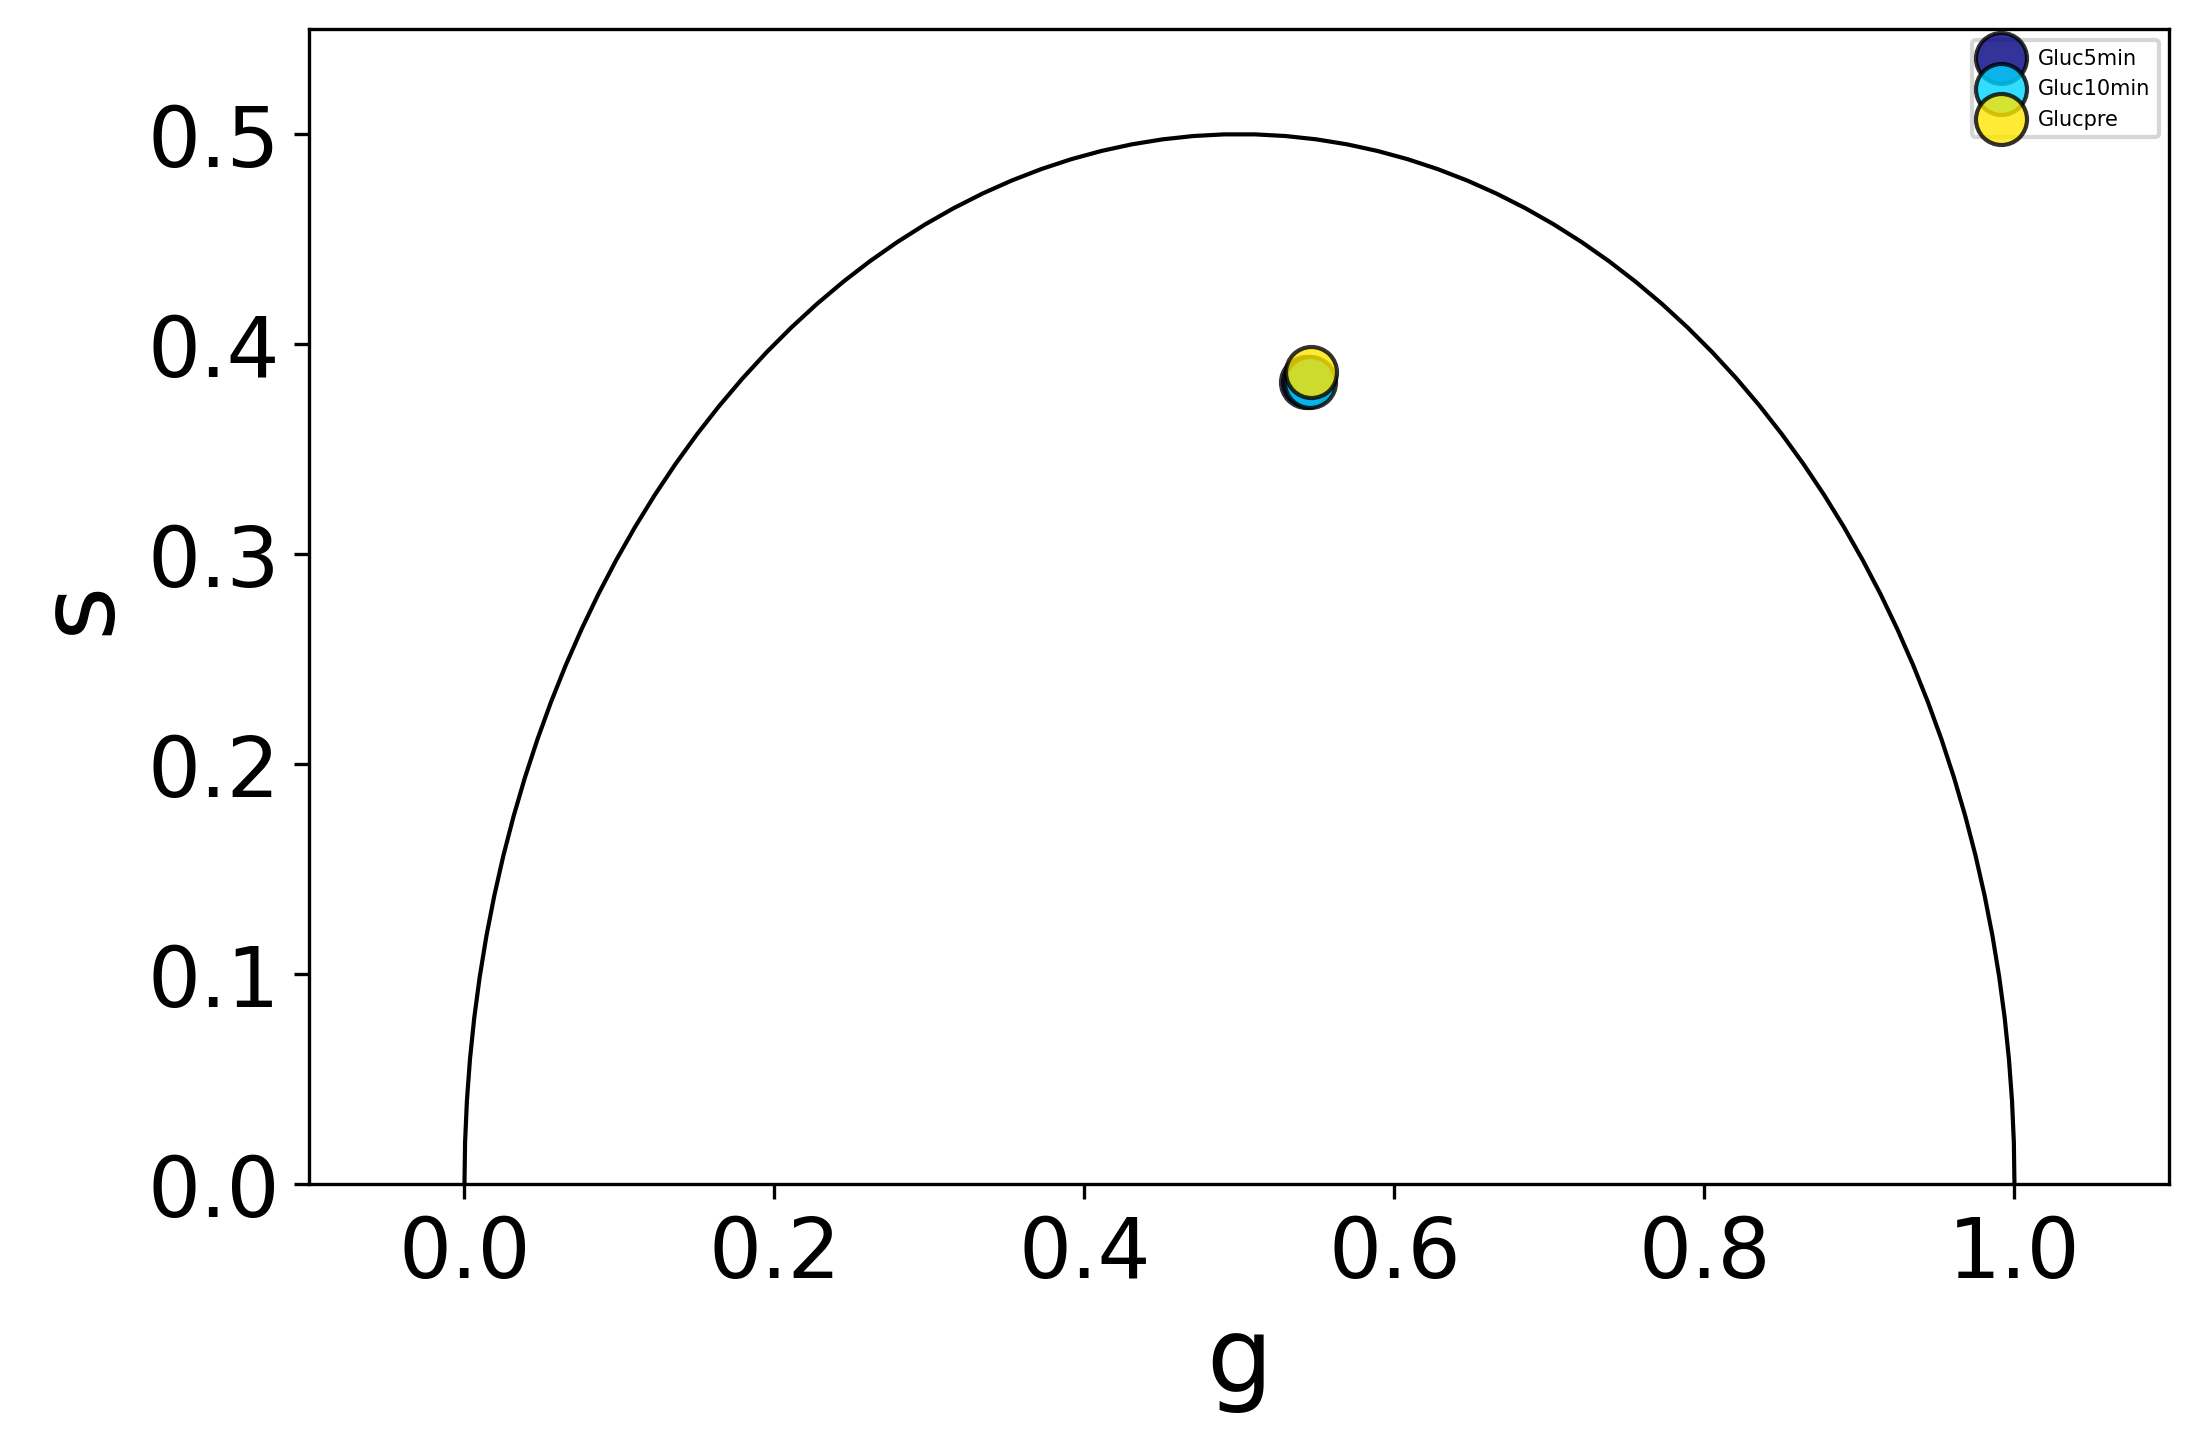

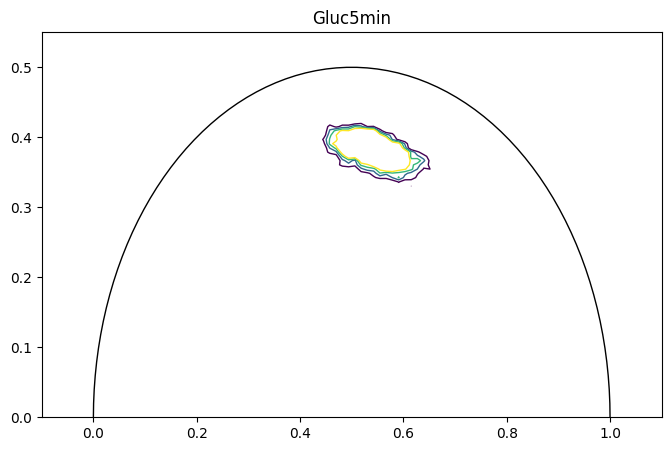

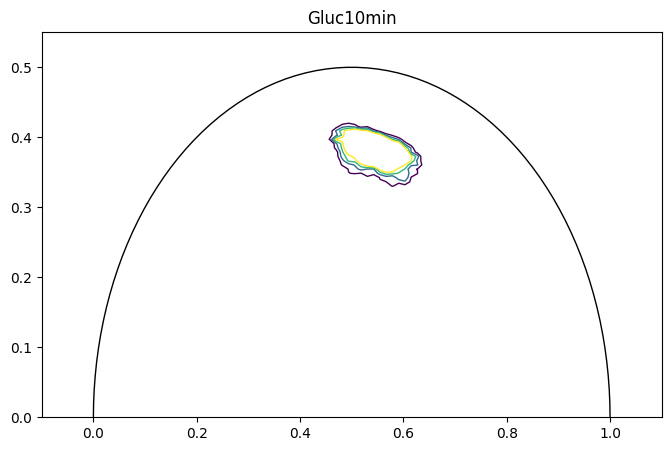

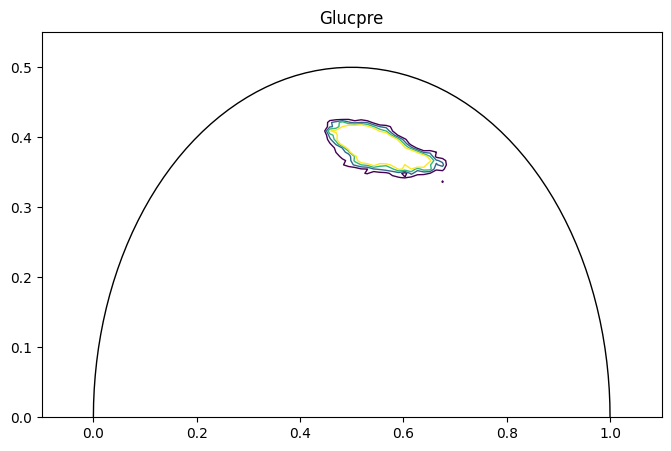

In [ ]:
import numpy as np
from scipy import signal
import math
import struct
import zlib
import matplotlib.pyplot as plt
import matplotlib
from tabulate import tabulate
import glob
import time
import pandas as pd
import plotly.express as px
import warnings
import re
from sklearn.decomposition import PCA
from scipy.signal import medfilt2d
import os
from skimage.filters import threshold_otsu
R64_paths=[]
directory='/content/'
for filename in os.listdir(directory):
    # Check if the file name contains the substring you want to replace
    if '(' in filename or ')' in filename:
        # Create the new file name by replacing the desired substrings
        new_filename = filename.replace(' (', '').replace(')', '')

        # Construct the full file paths
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_filename)

        # Rename the file
        os.rename(old_path, new_path)



warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

#check all the R64 files in the directory
if file_ext == 'R64':
	datasets=dataset_list(analysis)
elif file_ext == 'ref':
	datasets=refdataset_list(analysis)
print(datasets)
#sort data alphabetically
datasets.sort()

def natural_key(string_):
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

datasets=sorted(datasets,key=natural_key)
Contours=[]
ContourCount=-1
print('Datasets: ', datasets,'\n')

df = pd.DataFrame(columns = ["Sample", "G",'G std',"S",'S std','lifetime', 'lifetime std',
                             'sampled points','Contour PCA variability ratio','ContourIdx','phasor'])
figphasors,axphas =plt.subplots(1,1,figsize=(8,5),dpi=300)
universal_circle(axphas)
df_list=[]
for dataset in datasets:
	df_dataset= pd.DataFrame(columns = ["Sample","Pixel", "G","S",'lifetime','Intensity','ROI'])

	time_start = time.process_time()
	#stitch images together in case there is multiple input data - #create longer image of fixed width 512px and height n*512
	#pay attentio to the path if you download the code locally, it'slikely that tere is not a content folder
	if analysis == 'cumulative':
		R64_paths = glob.glob('/content/*' + dataset + '_*.'+file_ext, recursive=True)
	elif analysis == 'single file':
		R64_paths=glob.glob('/content/' + dataset, recursive=True)
	if analysis == 'cumulative':
		R64_paths=sorted(R64_paths,key=natural_key)
	tiff_paths=[]
	tiff_mask=[]
	dataset=dataset.replace('RPMI Citochine','Cytokines')
	dataset=dataset.replace('RPMI Controllo','Control')
	data=datastitch(R64_paths,file_ext)
	intensity = data[0,:,:]
	intensity0=intensity
	ph				= data[1,:,:]
	md				= data[2,:,:]

	if cell_segmentation == 'on':
		cellpose_mask, flows, styles, diams = model.eval(intensity, diameter=100,channels=[0,0],flow_threshold=2.9)
		#mask, flows, styles, diams = model.eval(intensity, diameter=None,channels=[0,0],flow_threshold=2.9)
		cellpose_mask = np.where(cellpose_mask > 0.5, 1, 0)
		intensity = intensity*cellpose_mask
		#intensity_image = intensity
		ph =	ph*cellpose_mask
		md =	md*cellpose_mask



	if threshold == 'multi-otsu':
		thr_I=threshold_multiotsu(image=intensity,classes=3)
		threshold=thr_I[0]*0.8
	elif threshold == 'otsu':
		thr_I=threshold_otsu(intensity)
		threshold=thr_I
	elif threshold == 'custom':
		threshold=threshold_value

	mask=np.select([intensity <= threshold, intensity > threshold], [np.zeros_like(intensity ), np.ones_like(intensity )])
	intensity = intensity*mask
	#intensity_image = intensity
	ph =	np.radians(ph)*mask
	md =	md*mask

	if analysis == 'cumulative':
		tiff_paths = glob.glob('/content/*' + dataset + '_*.tif', recursive=True)
		i64_list=list(glob.glob('*.i64', recursive=True))
		if len(i64_list)>0:
			i64_set = [path.replace('.R64', '') for path in R64_paths]
			i64_paths=[]
			for i64_item in i64_set:
				i64_paths.append(list(glob.glob(i64_item+'*.i64', recursive=True)))
			i64_paths=sorted(i64_paths,key=lambda x: natural_key(x[0]))
			i64_sublists=[]
			for i64 in i64_set:
					sublist = [paths for paths in i64_paths if any(i64 in path for path in paths)]
					i64_sublists.append(sublist)
			i64_masks=[]
			for i64_sublist in i64_sublists:
				i64_mask=np.zeros((512,512))
				for i64_entry in i64_sublist:
					print('i64_entry',i64_entry)
					if len(i64_entry)==1:
						i64data=decodei64(i64_entry[0])
						i64_mask=i64_mask+i64data
					elif len(i64_entry)>1:
						for entry in i64_entry:
							i64data=decodei64(entry)
							i64_mask=i64_mask+i64data
				i64_mask=np.where(i64_mask==0,0,1)
				i64_masks.append(i64_mask)
			i64_final_array = np.concatenate(i64_masks, axis=0)
			intensity = intensity*i64_final_array
			ph =	ph*i64_final_array
			md =	md*i64_final_array


	elif analysis == 'single file':
		i64_set=dataset.replace('.R64','')
		tiff_set=dataset.replace('.R64','.tif')
		i64_paths=glob.glob('/content/' + i64_set+'*.i64', recursive=True)
		tiff_paths=glob.glob('/content/' + tiff_set, recursive=True)
		i64_paths=sorted(i64_paths,key=natural_key)
		i64_mask=np.zeros((512,512))
		for i64_path in i64_paths:
			i64data=decodei64(i64_path)
			i64_mask=i64_mask+i64data
		if np.count_nonzero(i64_mask) > 0:
			i64_mask=np.where(i64_mask==0,0,1)
			intensity = intensity*i64_mask
			ph =	ph*i64_mask
			md =	md*i64_mask

	#phasorplot data points
	med_x0,med_y0=phasor(ph,md)
	if median_extent>0:
		#use medfilt2d for fast approach
		#med_x0=medfilt2d(med_x0, kernel_size=median_extent)
		#med_y0=medfilt2d(med_y0, kernel_size=median_extent)
		med_x0=scipy.ndimage.median_filter(med_x0, median_extent)
		med_y0=scipy.ndimage.median_filter(med_y0, median_extent)

		#ph,md = gaussian_fine_smoothing(ph,md,gauss_extent)

	lt0=simple_lt(med_x0,med_y0)
	lt0=np.where(np.isfinite(lt0),lt0,0)
	df_dataset['Intensity']= np.ravel(intensity).tolist()
	df_dataset['G']= np.ravel(med_x0).tolist()
	df_dataset['S']= np.ravel(med_y0).tolist()
	df_dataset['lifetime']= np.ravel(lt0).tolist()
	df_dataset['Sample']= np.ravel([dataset]*np.size(lt0)).tolist()
	df_dataset['Pixel'] = df_dataset.index
	df_dataset['ROI'] = np.zeros(np.size(lt0)).astype(int)
	df_dataset['phasor'] = np.zeros(np.size(lt0)).astype(int)

	#generate histogram with polished data
	df_filtered=df_dataset[df_dataset.Intensity>0.0001]
	df_filtered=df_filtered[df_filtered.G>0.0001]
	df_filtered=df_filtered[df_filtered.S>0.0001]
	hist,filtered_array,xedges,yedges,color = polished_hist(df_filtered.G, df_filtered.S, histogram_bins);
	hist_filtered = hist*filtered_array
	limits =	[xedges[0],xedges[-1],yedges[0],yedges[-1]]

	#Contour Plot normalization
	hist_filtered=hist_filtered/np.amax(hist_filtered)

	figscatter,ax=plt.subplots(1,1,figsize=(8,5),dpi=100)
	ax.set_title(dataset)
	universal_circle(ax)
	#irirefplot2(ax)
	# Determine the levels for the contour plot (6 levels)
	num_levels = 8

	# Calculate the levels by excluding the lowest value from the data
	hist_filtered_values=hist_filtered[hist_filtered>0]
	#hist_filtered_values=hist_filtered_values[1::]
	hist_filtered_min=0.001*np.max(hist_filtered_values)
	hist_filtered_values=hist_filtered_values[hist_filtered_values>hist_filtered_min]
	vmin=hist_filtered_min
	vmax = np.percentile(hist_filtered_values, th_percentile)
	#vmin = np.percentile(hist_filtered, 100 / num_levels)
	frequency_levels = list(np.linspace(vmin, vmax, num=num_levels))
	frequency_levels=frequency_levels[bottom_frequency_level:-1]

	cs=contour_plot(hist_filtered, frequency_levels,limits,ax)
	PhasorArray, PerimetersArray=analyze_contours(cs.allsegs)


	print('PhasorArrays',np.shape(PhasorArray))
	ROIs=0
	for PhasorContour in PerimetersArray:
		contour_check=isinsegment(df_filtered.G, df_filtered.S,df_filtered.Intensity, PhasorContour)
		ROI_extent=np.count_nonzero(contour_check)
		print('ROI extent',ROI_extent)
		if ROI_extent>ROI_min_extent:
			ROIs=ROIs+1
			Contours.append(PhasorContour)
			ContourCount=int(ContourCount+1)
			df_filtered.ROI= df_filtered.ROI+ROIs*contour_check
			df_ROI=df_filtered.loc[contour_check]
			df_subset = df_dataset.loc[df_ROI.Pixel.tolist(), 'ROI'].copy()
			df_subset.iloc[:] = ROIs
			df_dataset.loc[df_ROI.Pixel.tolist(), 'ROI'] = df_subset
			varatio=phasorPCA(np.stack((df_ROI.G,df_ROI.S)).T)
			phasorROIs=0
			for PhasorCore in PhasorArray:
				c_x=np.mean(PhasorCore[:,0])
				c_y=np.mean(PhasorCore[:,1])
				if c_x>np.min(df_ROI.G) and c_x<np.max(df_ROI.G) and c_y>np.min(df_ROI.S) and c_y<np.max(df_ROI.S):
					phasor_check=isinsegment(df_ROI.G,df_ROI.S,df_ROI.Intensity, PhasorCore)
					#coreG,coreS,core_intensity,core_extent,position_check=isinsegment(df_ROI.G,df_ROI.S,df_ROI.Intensity, PhasorCore)
					core_extent=np.count_nonzero(phasor_check)
					print('Phasor Extent',core_extent)
					if core_extent>phasor_min_extent:
								phasorROIs=phasorROIs+1
								df_phasor = df_ROI.loc[phasor_check]
								list_of_indices = df_phasor.index.tolist()
								df_dataset.loc[list_of_indices, 'phasor'] = phasorROIs
								print(phasorROIs,'phasorROIs')
								lt, lt_std, phasor_position, phasor_std=lifetime_computation(df_phasor.G,df_phasor.S,df_phasor.Intensity,flim_frequency)
								weightedliftime=simple_lt(phasor_position[0],phasor_position[1])
								weightedliftime_err=np.sqrt(phasor_std[0]**2+phasor_std[0]**2)
								s_row = pd.Series([dataset,phasor_position[0], phasor_std[0],phasor_position[1],
																	phasor_std[1],weightedliftime,
																						weightedliftime_err, core_extent,varatio,ContourCount,phasorROIs], index = df.columns)
								#df = df.append(s_row,ignore_index=True)
								df=pd.concat([df,s_row.to_frame().T])
	time_elapsed = (time.process_time() - time_start)
	print('time spent on '+str(dataset)+ ' dataset: ',time_elapsed)
	df_list.append(df_dataset)

df.reset_index(inplace=True)
dfplot(df,axphas,cmap)

#axphas.legend(loc='upper right',title='Samples',fontsize=10)
if reference == 'on':
	refplot(axphas,purespecies,pure_lifetimes)
axphas.set_xlabel('g',fontsize=25)
axphas.set_ylabel('s',fontsize=25)
axphas.tick_params(axis='both', which='major', labelsize=20)
axphas.tick_params(axis='both', which='minor', labelsize=20)
axphas.legend(fontsize=5)
#axphas.legend(fontsize=15,bbox_to_anchor=(1.1, 1))

In [ ]:
df

,index,Sample,G,G std,S,S std,lifetime,lifetime std,sampled points,Contour PCA variability ratio,ContourIdx,phasor
0,0,Gluc10min,0.52093,0.021669,0.387436,0.011456,2.330802,0.030644,8298,0.79965,1,1


#REMOVAL OF FILES


In [ ]:
!rm *R64 #remove all R64 files
!rm *tif
!rm *i64
!rm *ref

#ROI Analysis#

##MORPHOLOGICAL ANALYSIS ROIs

ContourIdx
[0]
0
Gluc5min
Cluster:  0
G 0.5852152892709154 G std 0.024386036967784776 S 0.3743486259326836 S std 0.011965712905492122 lifetime 2.085585995143479 lifetime std 0.11129408020465711
Cluster:  1
G 0.5156820300041708 G std 0.023580021932989855 S 0.39031726367825914 S std 0.013647378035938863 lifetime 2.365125096017987 lifetime std 0.12955714044785757


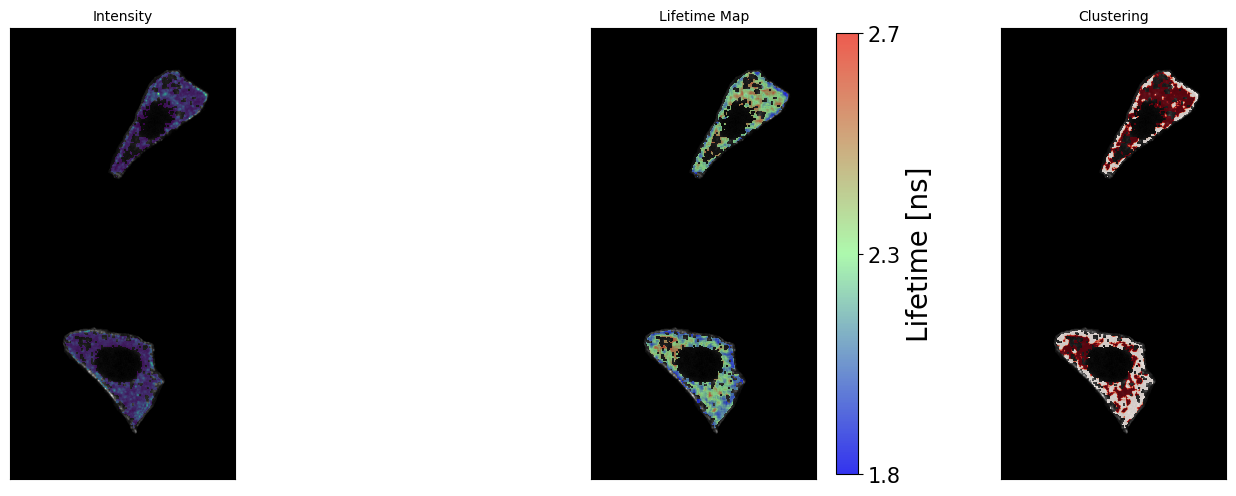

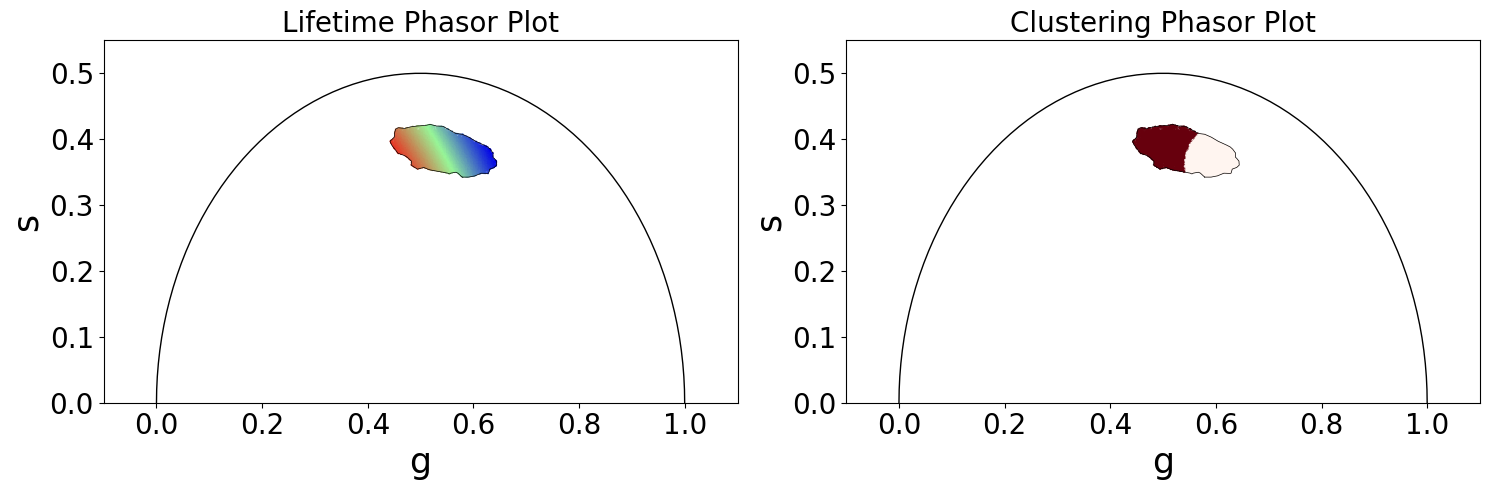

ContourIdx
[1]
1
Glucpre
Cluster:  0
G 0.5733065848169333 G std 0.022028757801652164 S 0.3828625487225143 S std 0.01277753226589115 lifetime 2.1076695260673155 lifetime std 0.10233880896528542
Cluster:  1
G 0.5083913375205938 G std 0.021252015106492047 S 0.3946918475288825 S std 0.015524133384689104 lifetime 2.377126088394822 lifetime std 0.10300119298745046


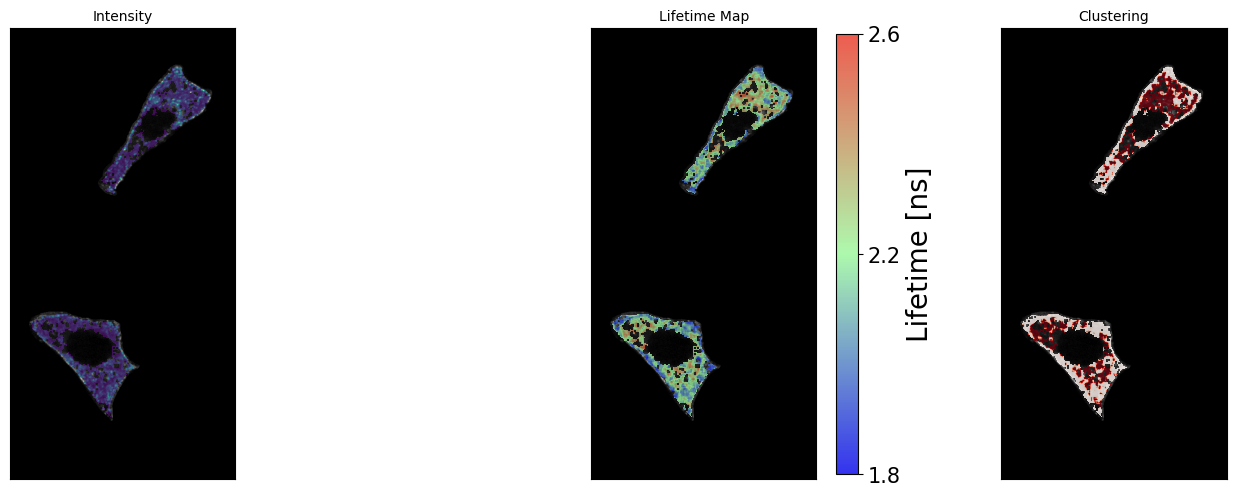

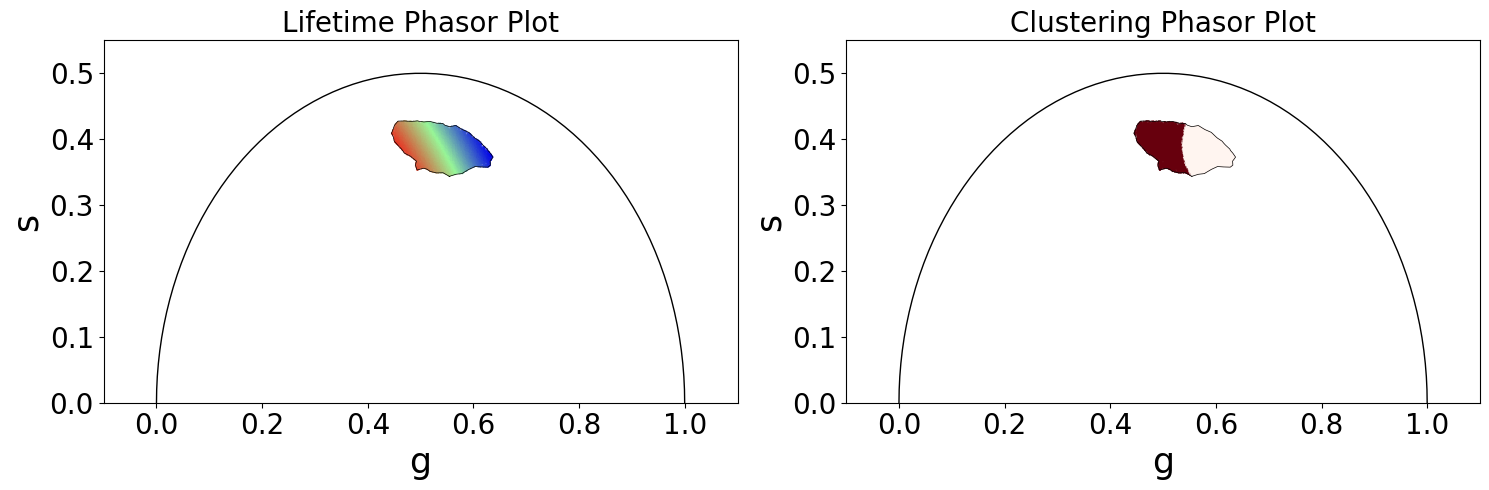

In [ ]:
from sklearn import cluster
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.cm as cm
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from scipy import stats
import seaborn as sns
from scipy.signal import savgol_filter
import seaborn as sns
combined_df = pd.concat(df_list)
#combined_df=combined_df[combined_df.ROI>0]
# Create a dropdown widget for the 'Sample' column
name_dropdown = widgets.Dropdown(options=combined_df['Sample'].unique(), description='Name:')
cluster_input = widgets.IntText(description='n clusters:')

# Create a dropdown widget for the 'ROI' column
roi_dropdown = widgets.Dropdown(options=combined_df['ROI'].unique(), description='ROI:')


# Create a button widget to trigger the filtering
button = widgets.Button(description='Analyse')

# Define a function to handle button click event
def filter_dataframe(_):
    fig,ax=plt.subplots(1,3,dpi=100,figsize=(15,5))
    figscatter,axs=plt.subplots(1,2,dpi=100,figsize=(15,5))
    name = name_dropdown.value
    roi = roi_dropdown.value
    n_clusters = int(cluster_input.value)
    dataset_mapping(name,combined_df, df,roi,n_clusters ,ax,fig,axs)
    fig.tight_layout()
    figscatter.tight_layout()

# Attach the button click event handler
button.on_click(filter_dataframe)

# Display the dropdowns and the button
#display(name_dropdown, roi_dropdown, name_dropdown2, roi_dropdown2, button)
widgets.HBox([name_dropdown,roi_dropdown, cluster_input,button])





In [ ]:
df

,index,Sample,G,G std,S,S std,lifetime,lifetime std,sampled points,Contour PCA variability ratio,ContourIdx,phasor
0,0,Cytokines,0.21608,0.013332,0.187512,0.013481,6.663048,0.018855,25653,0.651915,0,1
1,0,Cytokines,0.465682,0.020626,0.347615,0.010867,2.786096,0.02917,74340,0.843615,1,1


##STATISTICAL ANALYSIS ROIs

Dropdown(description='Name:', options=('Gluc5min', 'Glucpre'), value='Gluc5min')

Dropdown(description='ROI:', options=(1,), value=1)

Dropdown(description='Name 2:', options=('Gluc5min', 'Glucpre'), value='Gluc5min')

Dropdown(description='ROI 2:', options=(1,), value=1)

Dropdown(description='Variable:', options=('lifetime', 'G', 'S'), value='lifetime')

Button(description='Compare', style=ButtonStyle())

mann 3.557769910209863e-100
KstestResult(statistic=0.112, pvalue=6.990901300156074e-06, statistic_location=2.4136300279991296, statistic_sign=1)
Glucpre - 25th Percentile: 2.1391311886929953
Gluc5min - 25th Percentile: 2.1804207113781606

Glucpre - 50th Percentile: 2.2545828902307923
Gluc5min - 50th Percentile: 2.2907820006511552

Glucpre - 75th Percentile: 2.3715947709443315
Gluc5min - 75th Percentile: 2.4123280073950957

Central Tendency:
Glucpre Mean: 2.25671078958379
Gluc5min Mean: 2.2957213440875193

Spread:
Glucpre Standard Deviation: 0.1520691966899184
Gluc5min Standard Deviation: 0.16384340721196602

Skewness:
Glucpre Skewness: 0.08666355372030109
Gluc5min Skewness: 0.07782320220531548


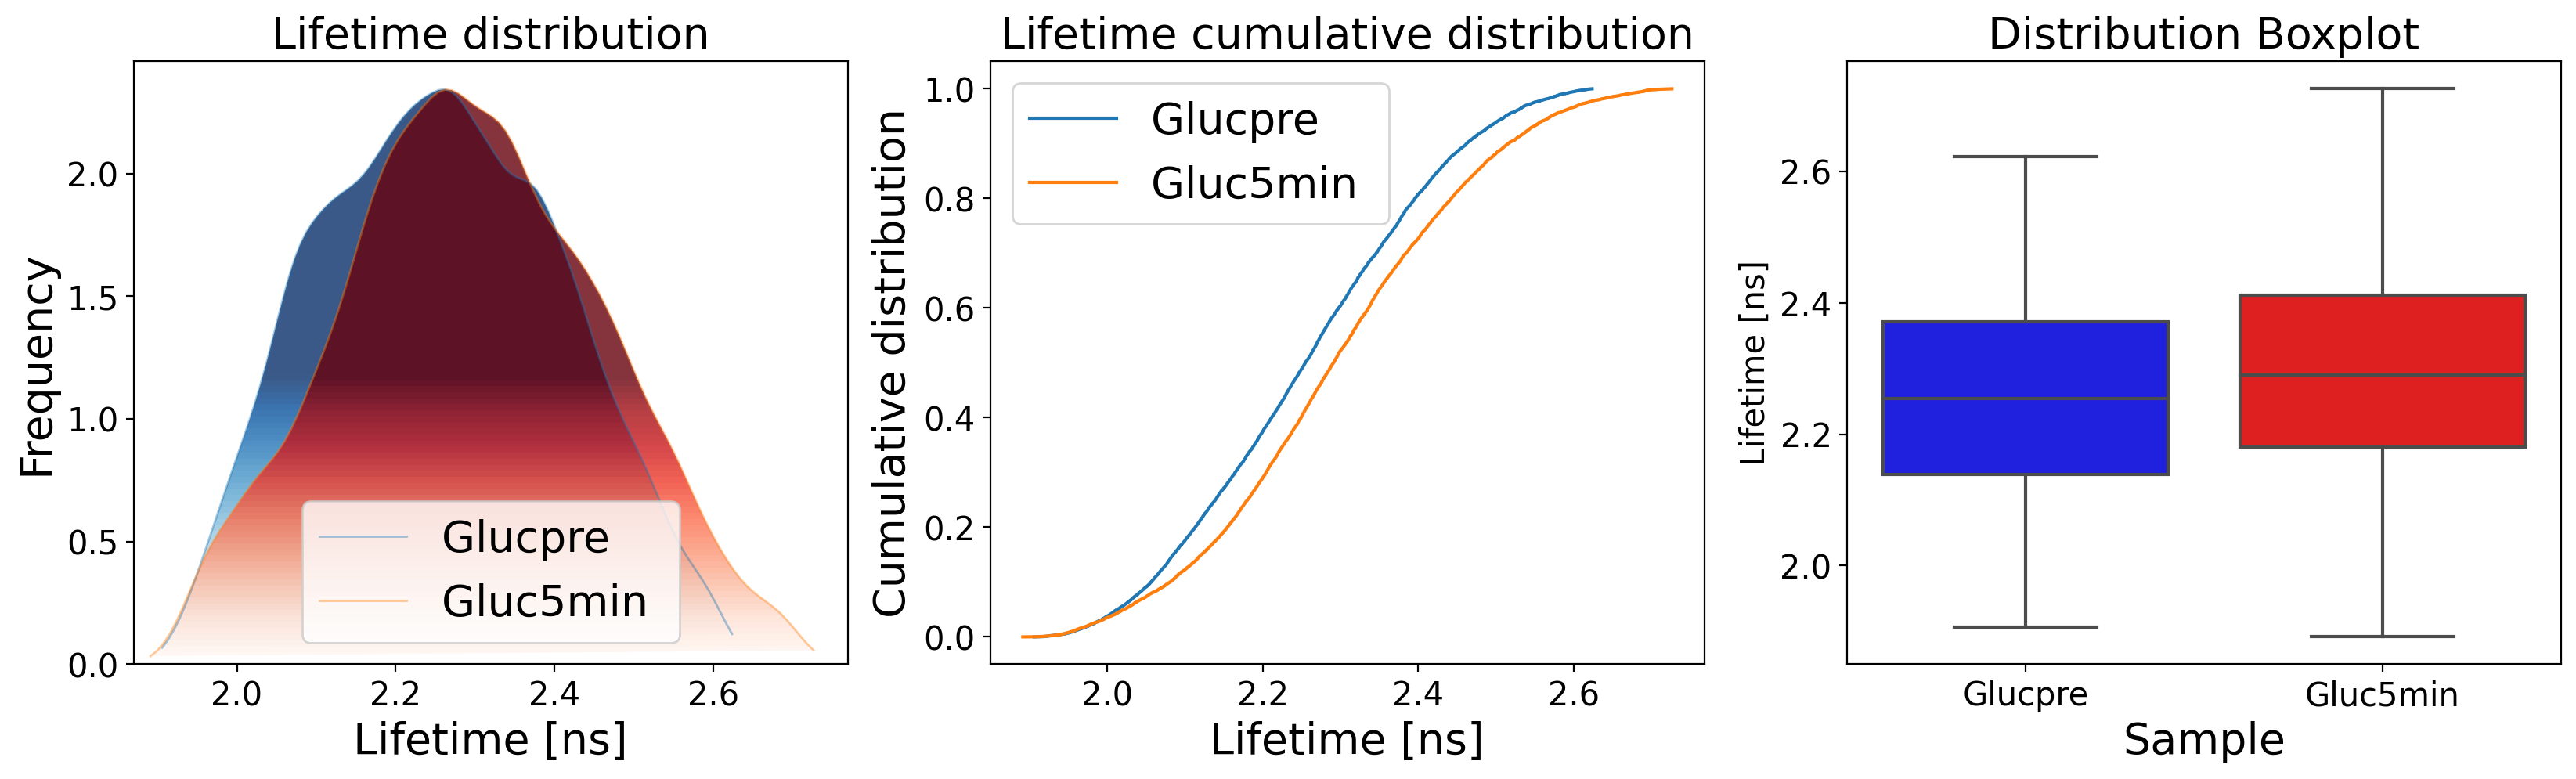

In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from scipy import stats
import seaborn as sns
from scipy.signal import savgol_filter
import seaborn as sns

combined_df = pd.concat(df_list)
combined_df=combined_df[combined_df.ROI>0]
combined_df=combined_df[combined_df.lifetime>0.0001]
# Create a dropdown widget for the 'Sample' column
name_dropdown = widgets.Dropdown(options=combined_df['Sample'].unique(), description='Name:')

# Create a dropdown widget for the 'ROI' column
roi_dropdown = widgets.Dropdown(options=combined_df['ROI'].unique(), description='ROI:')

name_dropdown2 = widgets.Dropdown(options=combined_df['Sample'].unique(), description='Name 2:')

# Create a dropdown widget for the 'ROI' column
roi_dropdown2 = widgets.Dropdown(options=combined_df['ROI'].unique(), description='ROI 2:')
#Pick variable
variable_dropdown = widgets.Dropdown(options=['lifetime','G','S'], description='Variable:')
# Create a button widget to trigger the filtering
button = widgets.Button(description='Compare')

# Define a function to handle button click event
def filter_dataframe(_):
    fig,ax=plt.subplots(1,3,dpi=200,figsize=(20,5))
    name = name_dropdown.value
    roi = roi_dropdown.value
    name2 = name_dropdown2.value
    roi2 = roi_dropdown2.value
    variable=variable_dropdown.value
    statistic_compare( name,roi,name2,roi2,combined_df,ax,variable)


# Attach the button click event handler
button.on_click(filter_dataframe)

# Display the dropdowns and the button
display(name_dropdown, roi_dropdown, name_dropdown2, roi_dropdown2,variable_dropdown, button)


In [ ]:
df

,index,Sample,G,G std,S,S std,lifetime,lifetime std,sampled points,Contour PCA variability ratio,ContourIdx,phasor
0,0,Gluc5min,0.530897,0.028064,0.389003,0.011297,2.27574,0.039689,12525,0.901756,0,1
1,0,Glucpre,0.54291,0.031648,0.389153,0.011395,2.216407,0.044758,14367,0.903933,1,1


NameError: ignored

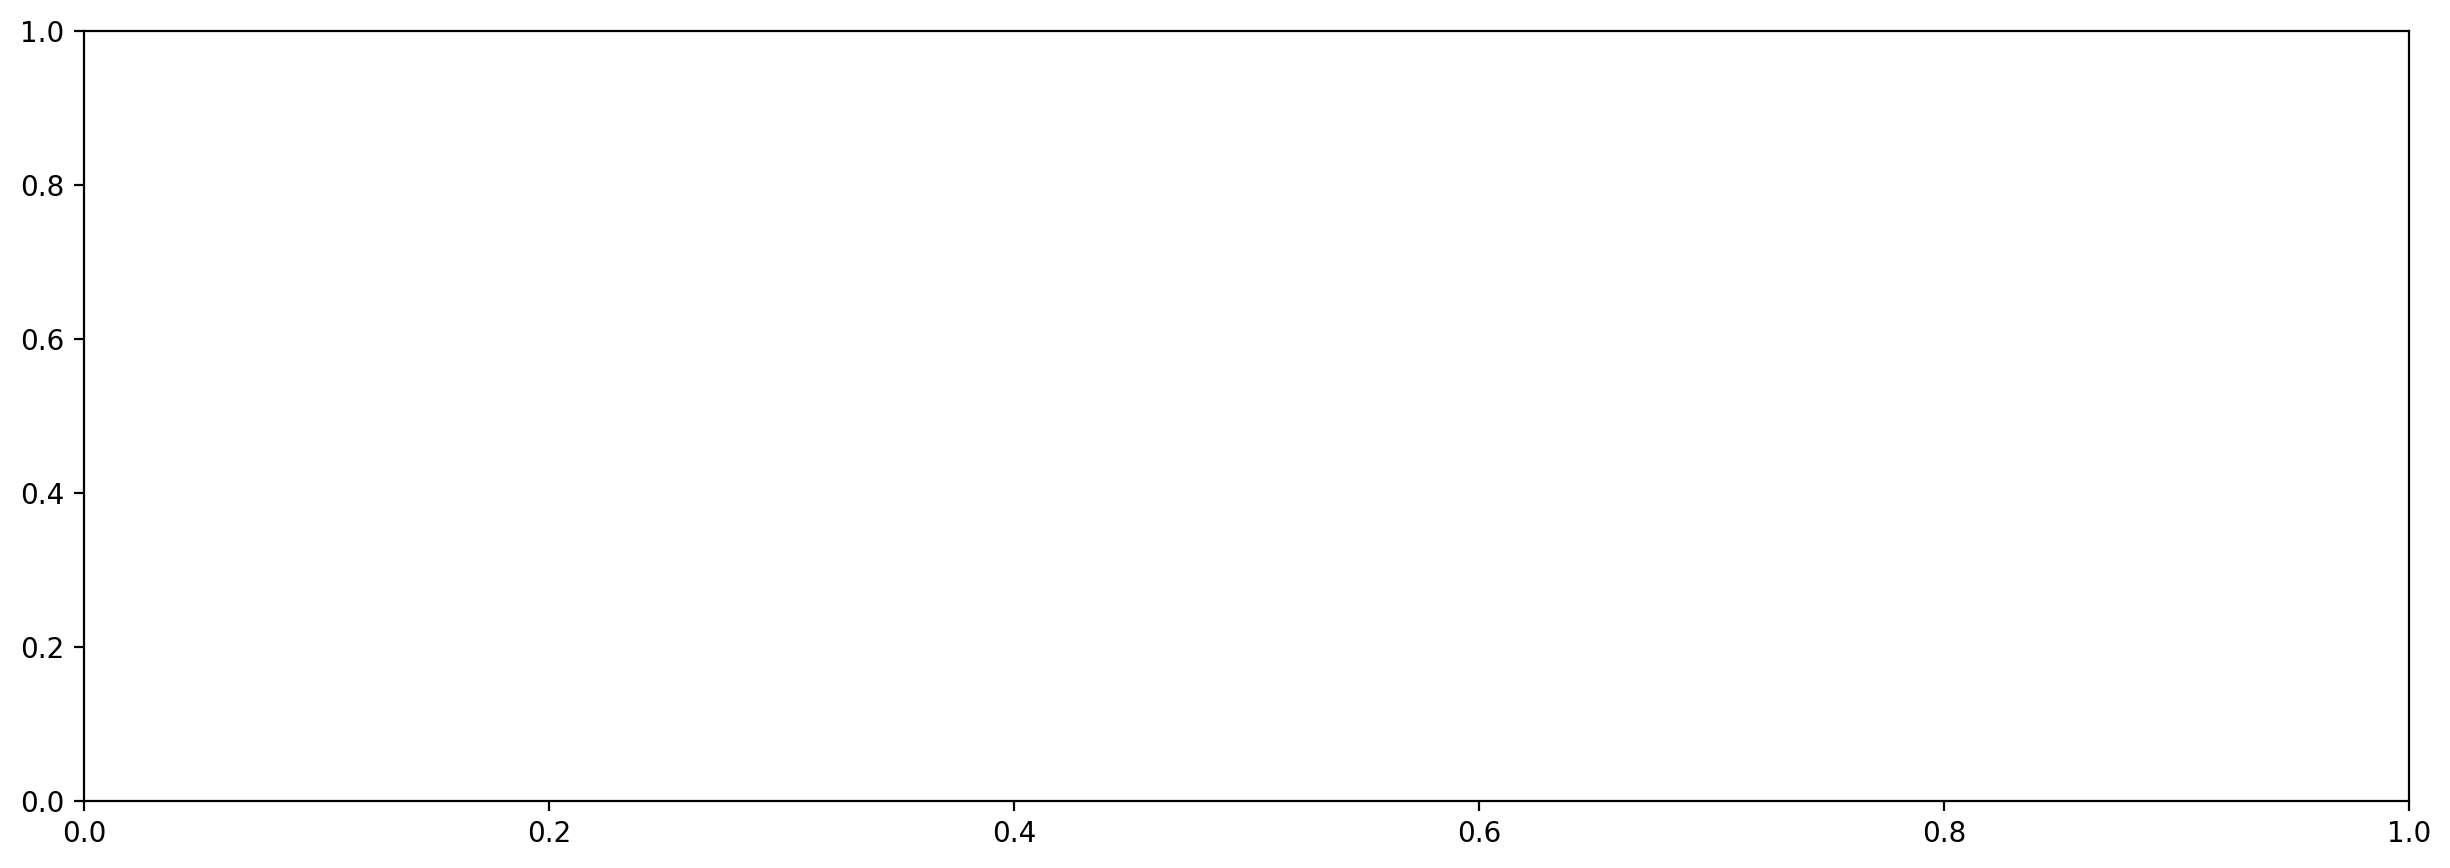

In [ ]:
import seaborn as sns

fig,ax=plt.subplots(1,1,dpi=200,figsize=(15,5))
#sns.boxplot(ax=ax,x="Sample", y='lifetime',data=combined_df)
sns.boxplot(ax=ax,x="Sample", y='lifetime',data=df_common_filtered)
sns.swarmplot(ax=ax,x="Sample", y='lifetime',data=df_common_filtered)
plt.xticks(rotation=45)

In [ ]:
df

,index,Sample,G,G std,S,S std,lifetime,lifetime std,sampled points,Contour PCA variability ratio,ContourIdx,phasor
0,0,carc,1.015312,0.004624,0.027406,0.004175,NaN,0.00654,6314,0.58875,0,1
1,0,carc SLN,0.36606,0.00513,0.344931,0.003696,3.418668,0.007254,44946,0.628442,1,1
2,0,carc SLN placebo,0.349289,0.00672,0.327434,0.004864,3.648164,0.009503,31126,0.748272,2,1
3,0,carc placebo,0.348936,0.006848,0.328084,0.005183,3.646308,0.009684,33279,0.749983,3,1


##SELECTION FROM PHASOR PLOT

In [ ]:
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.6 MB/s eta 0:00:00


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# Create a dropdown widget to allow the user to select an item from the list
name_dropdown = widgets.Dropdown(options=combined_df['Sample'].unique(), description='Name:')

# Create a dropdown widget for the 'ROI' column
roi_dropdown = widgets.Dropdown(options=combined_df['ROI'].unique(), description='ROI:')

display(name_dropdown, roi_dropdown)

selected_name = name_dropdown.value
selected_roi  = roi_dropdown.value
# You can now use 'selected_item' as a string in the subsequent cells
print(f"The user selected: {selected_name}")

Dropdown(description='Name:', options=(' twen', 'carc', 'carc SLN', 'carc SLN placebo', 'carc placebo', 'carca…

Dropdown(description='ROI:', options=(1,), value=1)

The user selected:  twen


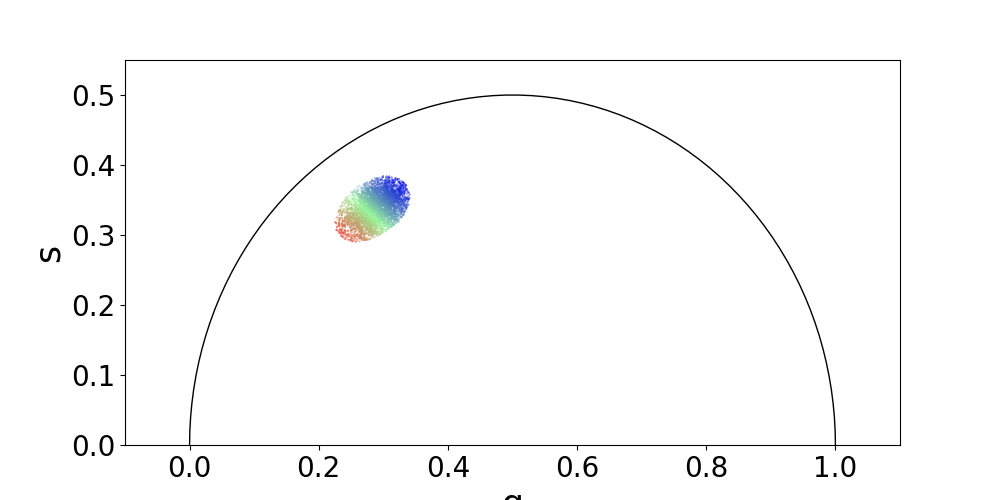

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
from matplotlib.widgets import LassoSelector
%matplotlib widget
button_select = widgets.Button(description='Select')
# Define a function to handle button click event

fig, ax = plt.subplots(1, 1, dpi=100, figsize=(10, 5))
universal_circle(ax)
dataset_selection_plot(selected_name,combined_df,selected_roi,ax)
selected_verts = []

def onselect(verts):
    # Store the selected vertices in the 'selected_verts' array
    selected_verts.append(verts)

lineprops= {'color': 'red',
        'linewidth': 2.5, 'alpha': 1}
lasso = LassoSelector(ax, onselect,props=lineprops)


In [ ]:
output.disable_custom_widget_manager()

#MULTI PHASOR ANALYSIS#

##SAVE DATAFRAME

In [ ]:
df.to_csv('Exported_data.csv')

##LOAD DATAFRAME (.CSV)

In [ ]:
import pandas as pd
#df_common_filtered.to_csv('Doxoves in time.csv', index=False)
df_reopened = pd.read_csv('Doxoves in time.csv')
df_common_filtered=df_reopened.copy()

## MOLAR FRACTIONS


In [ ]:
def molar_denominator(Ix_list, eps_x_list, Qx_list):
    total_sum = 0
    for i in range(3):
        total_sum += Ix_list[i] / (eps_x_list[i] * Qx_list[i])
    return total_sum

def molar_conversion(Ix_list,eps_list, QY_list):
  num = np.array(Ix_list)/(np.array(eps_list)* np.array(QY_list))
  denom = molar_denominator(Ix_list, eps_list, QY_list)
  molar_fractions = num/denom
  return molar_fractions

In [ ]:
def Triangle_IntensityFractions(phase1,phase2,phase3,target,labels):

  colours = {labels[0]: '#009CB1',
          labels[1]: '#00F983',
          labels[2]: '#1D287A'}


  Total_Area = abs((0.5)*(phase1[0]*(phase2[1]-phase3[1])+phase2[0]*(phase3[1]-phase1[1])+phase3[0]*(phase1[1]-phase2[1])))
  vertices=[phase1, phase2, phase3]

  percentage=[]

  for vertex in vertices:
    sub_vertices = [x for x in vertices if x != vertex]
    Vertex_A = sub_vertices[0]
    Vertex_B = sub_vertices[1]
    Area=abs((0.5)*(Vertex_A[0]*(Vertex_B[1]-target[1])+Vertex_B[0]*(target[1]-Vertex_A [1])+target[0]*(Vertex_A [1]-Vertex_B[1])))
    percentage.append(Area/Total_Area)



  max_index = percentage.index(max(percentage))
  #print('The most abundant phase in intensity is: ', labels[max_index])
  #print(labels, percentage,sum(percentage))
  explode = [0, 0, 0]
  explode[max_index]=0.2
  fig=plt.figure(figsize=(5,5))
  ax = fig.add_axes([0,0,1,1])
  my_circle = plt.Circle((0, 0), 0.85, color='white')
  ax.pie(percentage, labels=labels,explode=explode,autopct='%1.1f%%',colors=[colours[key] for key in labels],
          shadow=True, startangle=90,textprops={'fontsize': 25})
  ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  return percentage

def Segment_IntensityFractions(RefA,RefB,target,labels):

  colours = {'free': '#009CB1',
          'bound': '#00F983',
          'precipitate': '#1D287A'}

  Tot_distance = ((RefA[0] - RefB[0])**2 + (RefA[1] - RefB[1])**2)**0.5
  distanceA=((RefA[0] - target[0])**2 + (RefA[1] - target[1])**2)**0.5
  distanceB=((RefB[0] - target[0])**2 + (RefB[1] - target[1])**2)**0.5
  ratioA=(distanceB)/Tot_distance
  ratioB=(distanceA)/Tot_distance
  ratioA=(distanceB)/(distanceA+distanceB)
  ratioB=(distanceA)/(distanceA+distanceB)
  ratios=[ratioA,ratioB]
  max_index = ratios.index(max(ratios))
  explode = [0, 0]
  #explode[max_index]=0.5
  fig=plt.figure(figsize=(5,5))
  ax = fig.add_axes([0,0,1,1])
  my_circle = plt.Circle((0, 0), 0.85, color='white')
  ax.pie(ratios, labels=labels,explode=explode,autopct='%1.1f%%',colors=[colours[key] for key in labels],
          shadow=True, startangle=90,textprops={'fontsize': 25})
  ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.gca().add_artist(my_circle)
  plt.show()
  return ratioA,ratioB

In [ ]:
#e.g. doxo 0.200 crystal QY 0.150 ε 7510 ,1.002 free QY 4.23 ε 10 340,4.540 bound QY 19.17 ε 10 340

purespecies0 = input("Please enter first pure species name: ")
pure_lt0 = input("Please enter first pure species lifetime [ns]: ")
eps0 = input("Please enter first pure species extinsion molar coefficient: ")
QY0 = input("Please enter first pure species QY:")

purespecies1 = input("Please enter second pure species name: ")
pure_lt1 = input("Please enter second pure species lifetime: ")
eps1 = input("Please enter first pure species extinsion molar coefficient: ")
QY1 = input("Please enter second pure species QY: ")

purespecies2 = input("Please enter third pure species name: ")
pure_lt2 = input("Please enter third  pure species lifetime: ")
eps2 = input("Please enter third pure species extinsion molar coefficient: ")
QY2 = input("Please enter third pure species QY: ")

purespecies=[purespecies0,purespecies1,purespecies2]
pure_lifetimes=[float(pure_lt0),float(pure_lt1),float(pure_lt2)]
eps_list = [float(eps0),float(eps1),float(eps2)]
QY_list = [float(QY0),float(QY1),float(QY2)]
reference='on'


Please enter first pure species name: Crystal
Please enter first pure species lifetime [ns]: 0.200
Please enter first pure species extinsion molar coefficient: 0.150
Please enter first pure species QY:7510
Please enter second pure species name: free
Please enter second pure species lifetime: 1.002
Please enter first pure species extinsion molar coefficient: 4.23
Please enter second pure species QY: 10340
Please enter third pure species name: Bound
Please enter third  pure species lifetime: 4.540
Please enter third pure species extinsion molar coefficient: 19.17
Please enter third pure species QY: 10340


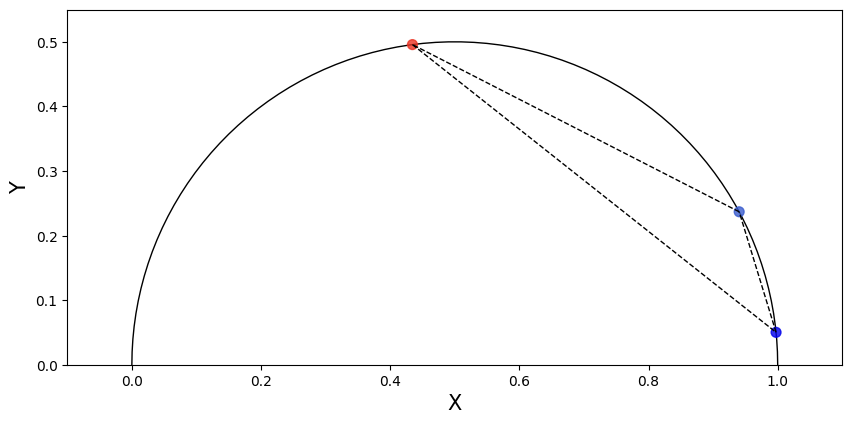

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
points1, points2,points3=refplot(ax,purespecies,pure_lifetimes)

<ipython-input-71-83de4ed161eb>:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(5,5))


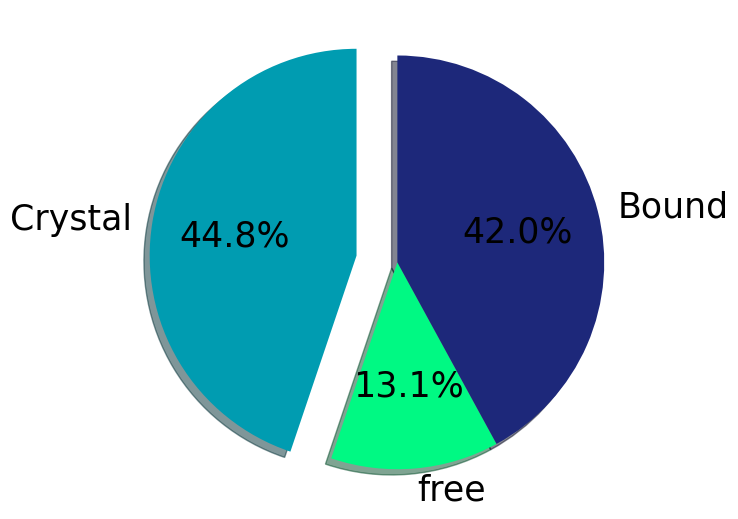

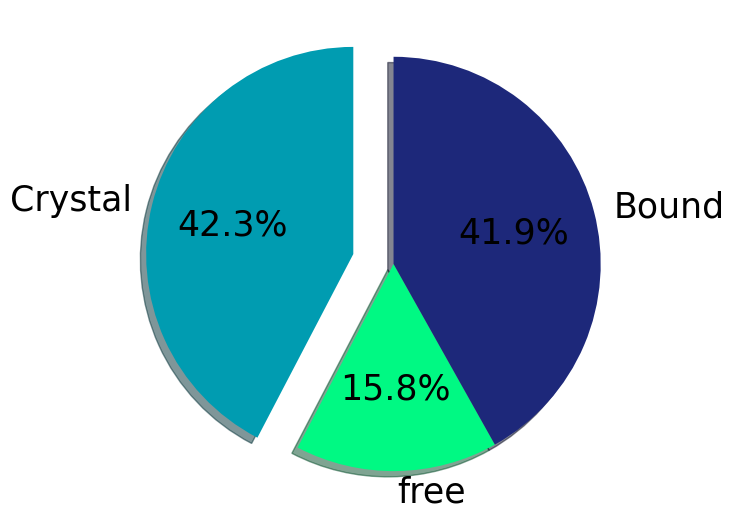

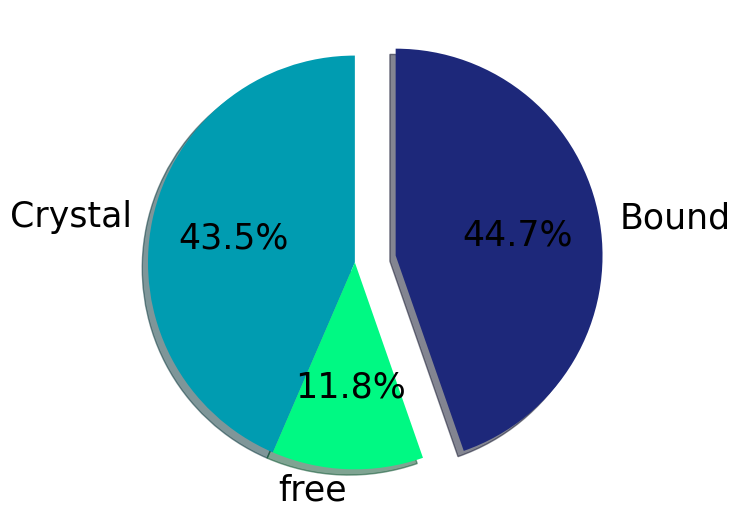

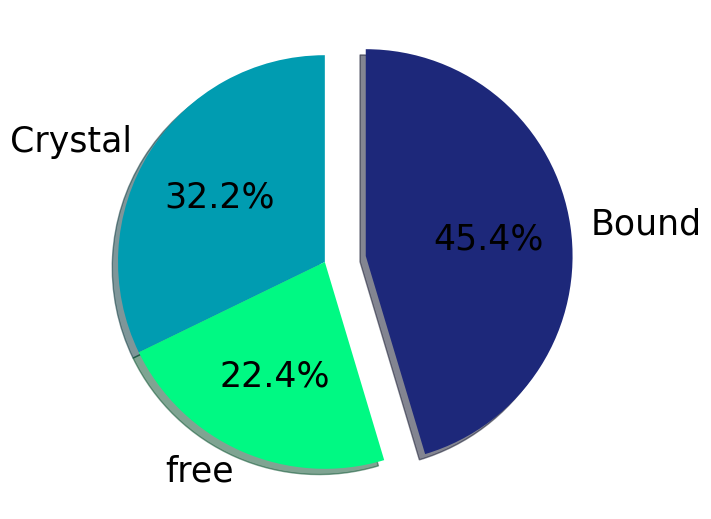

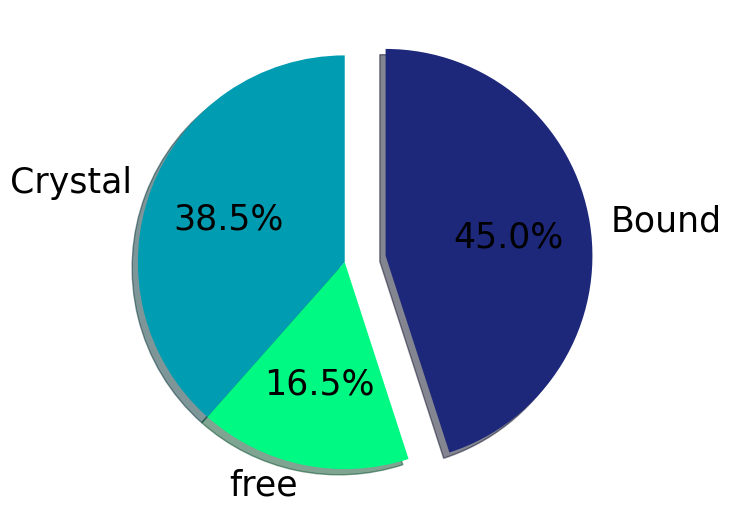

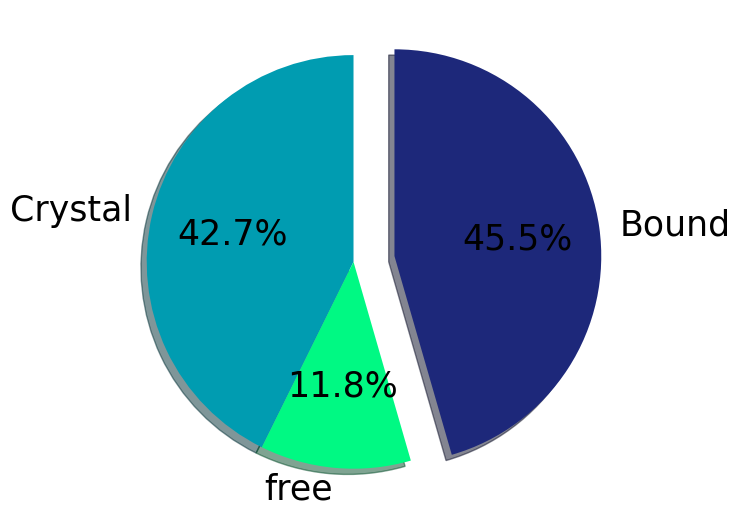

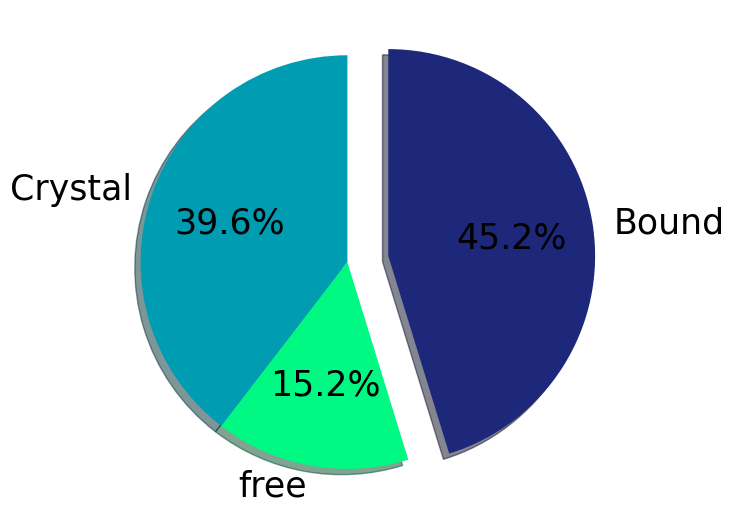

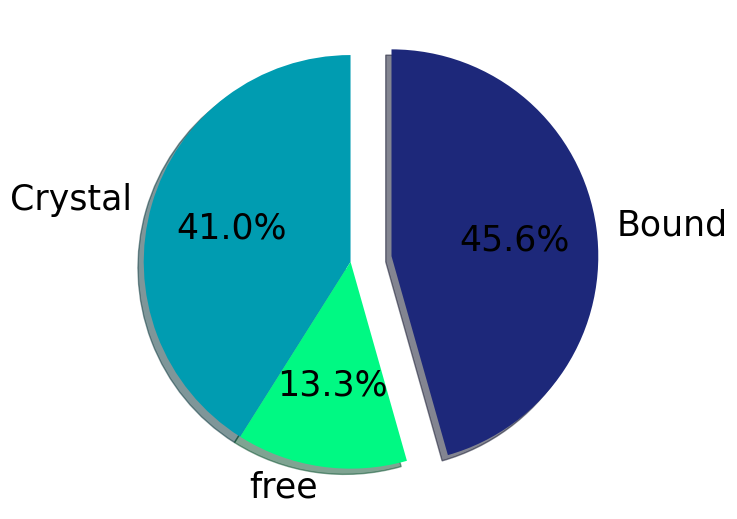

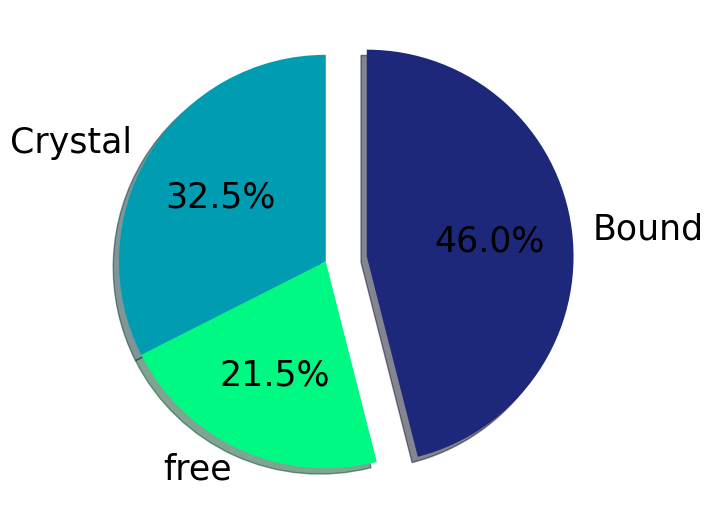

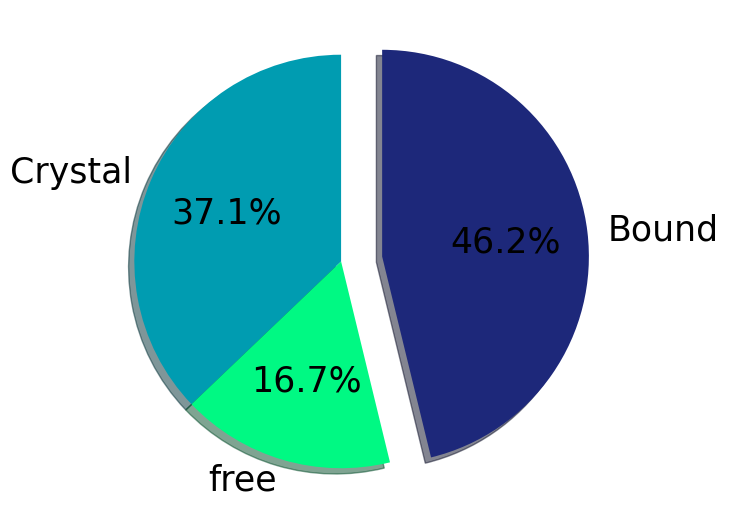

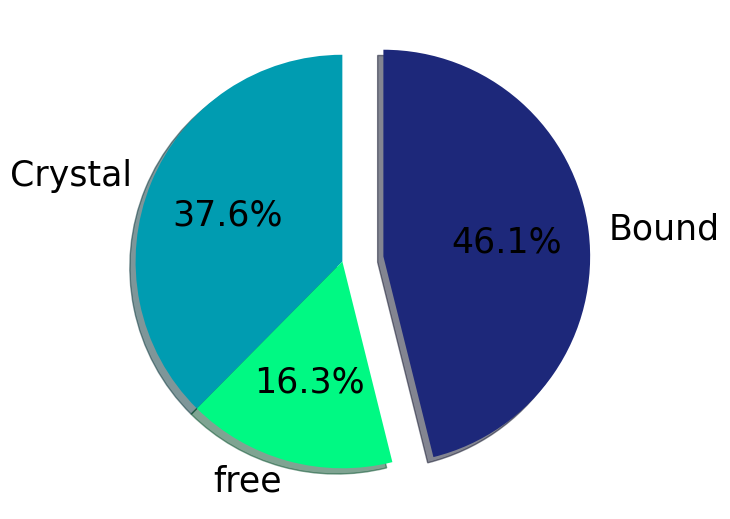

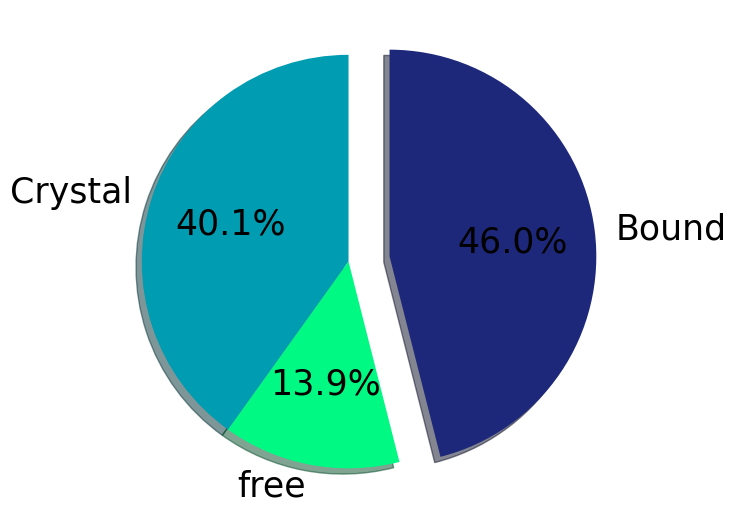

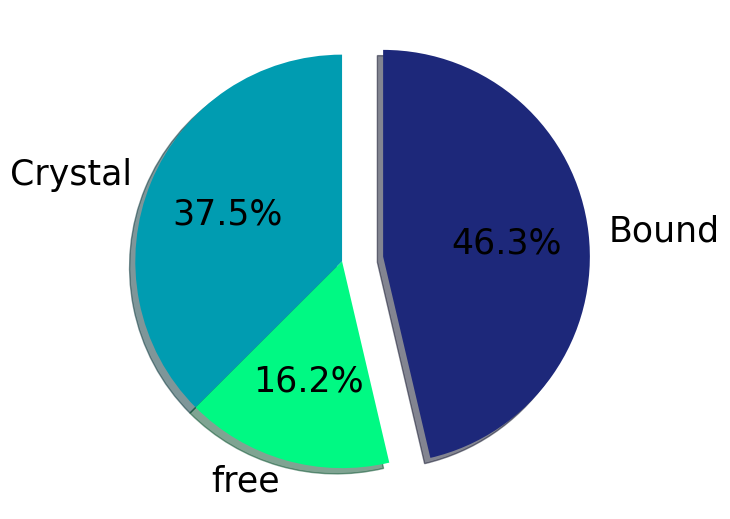

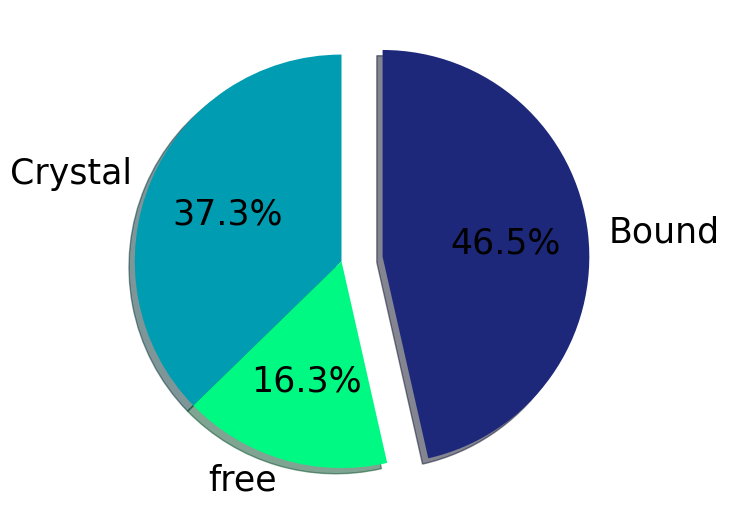

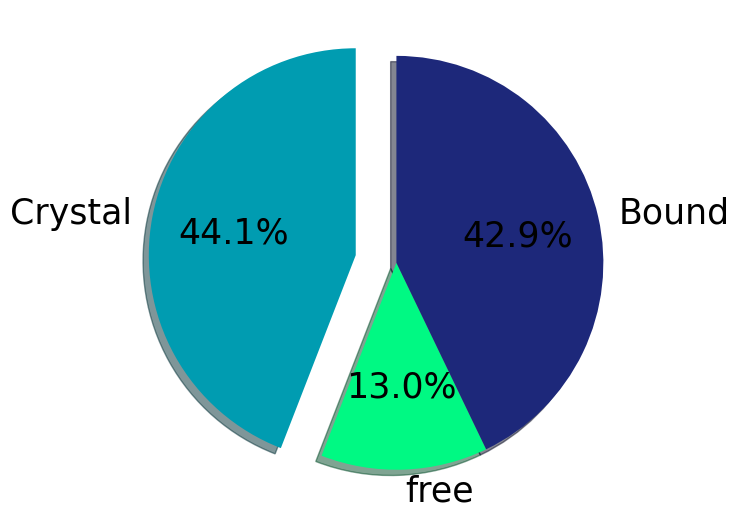

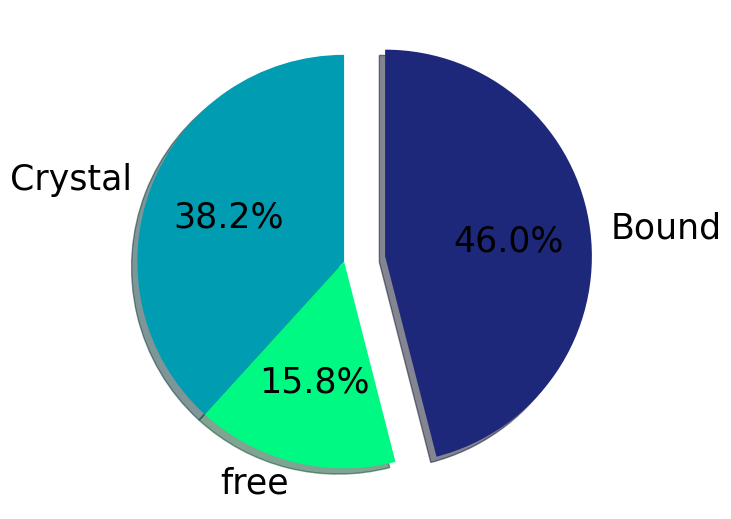

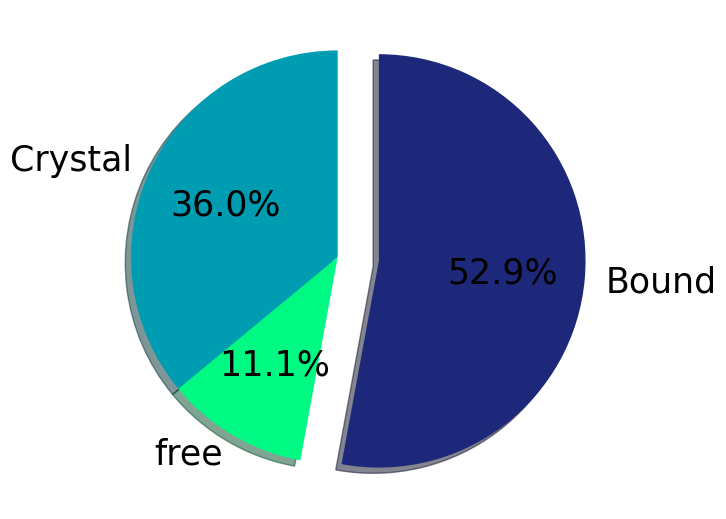

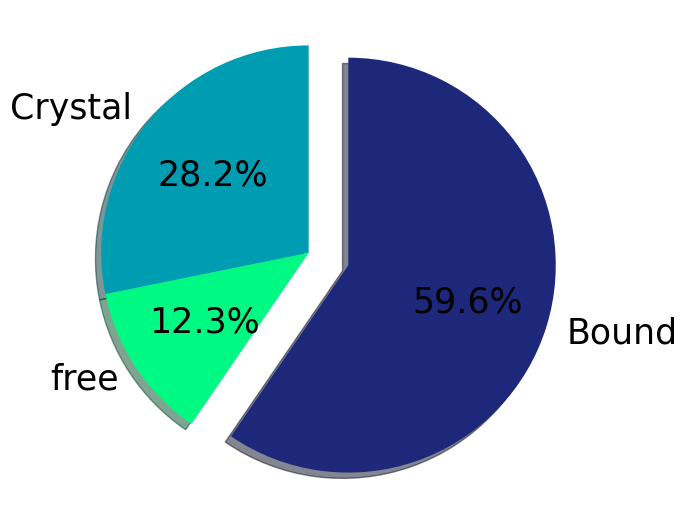

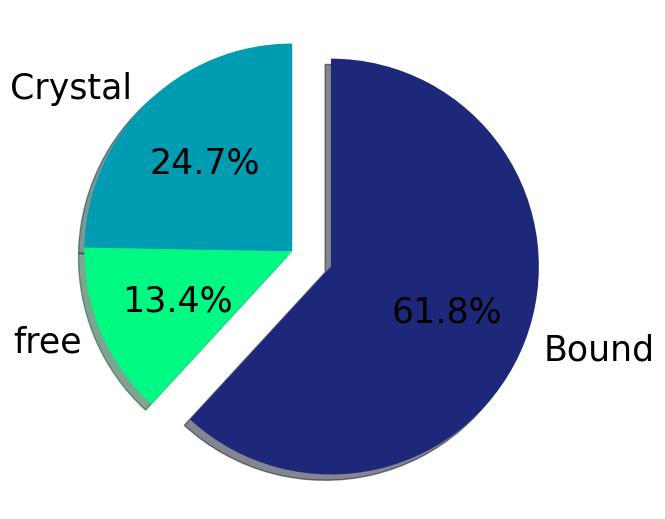

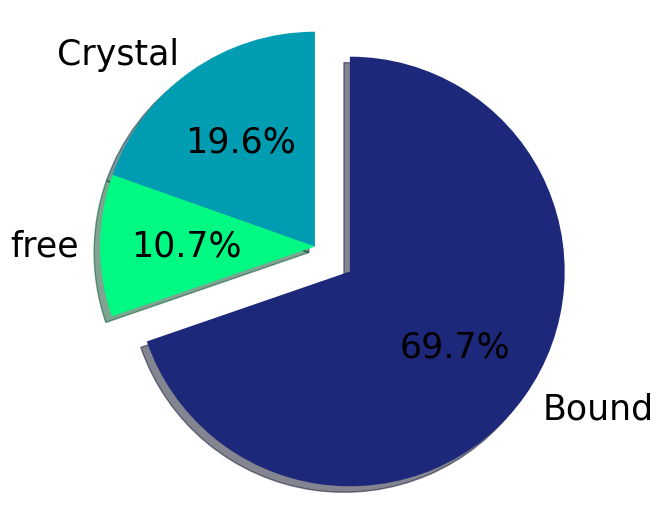

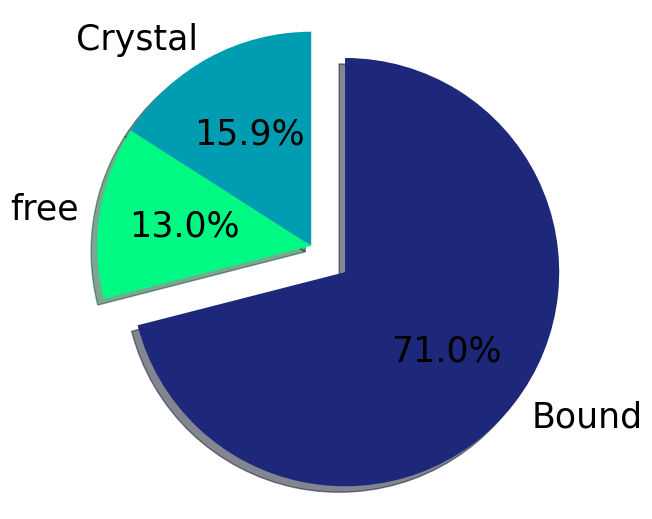

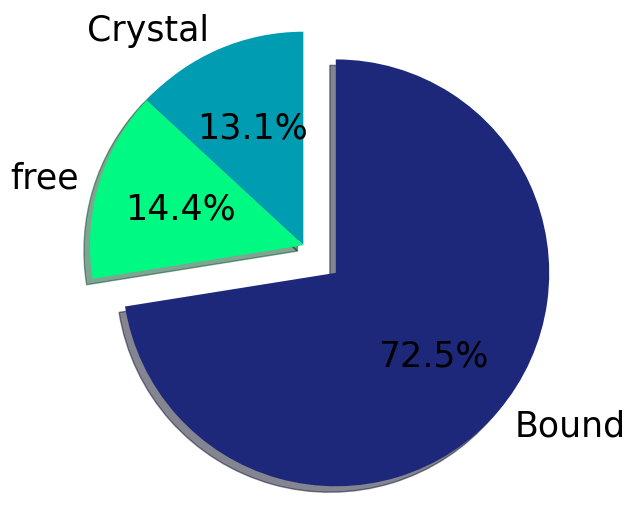

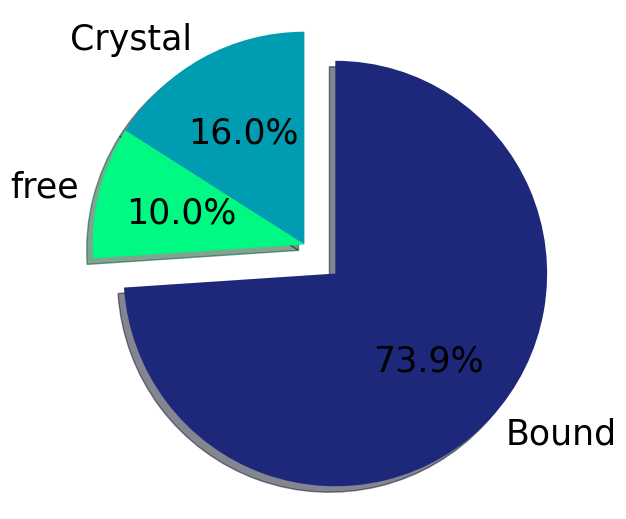

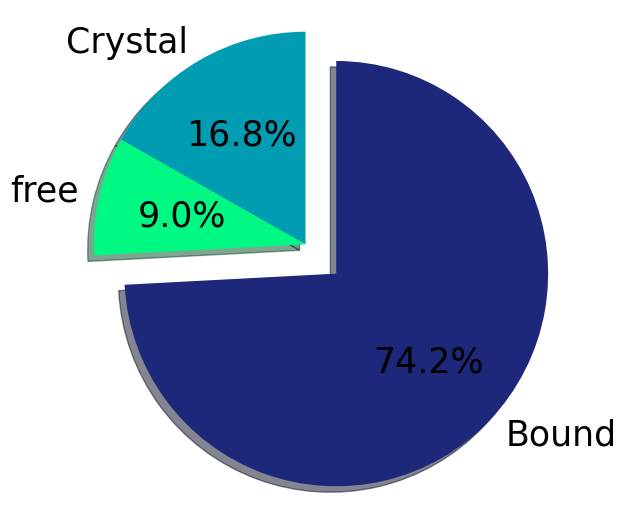

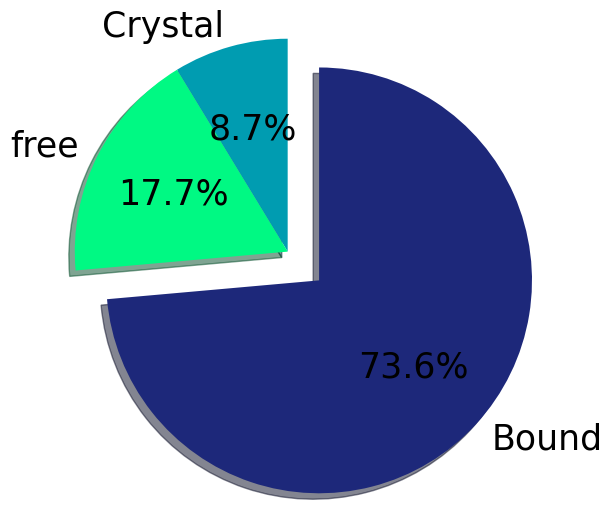

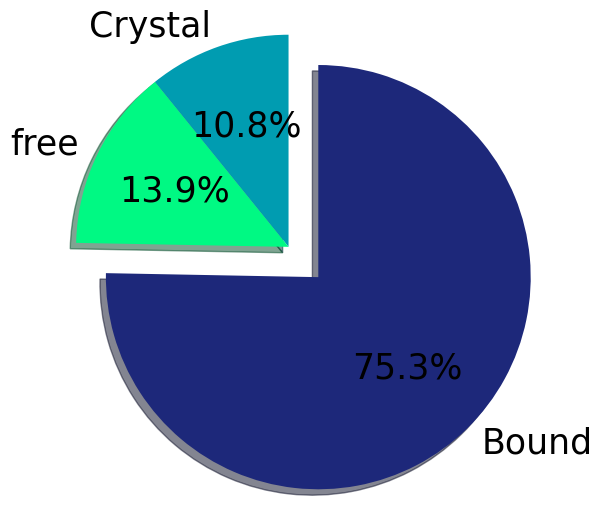

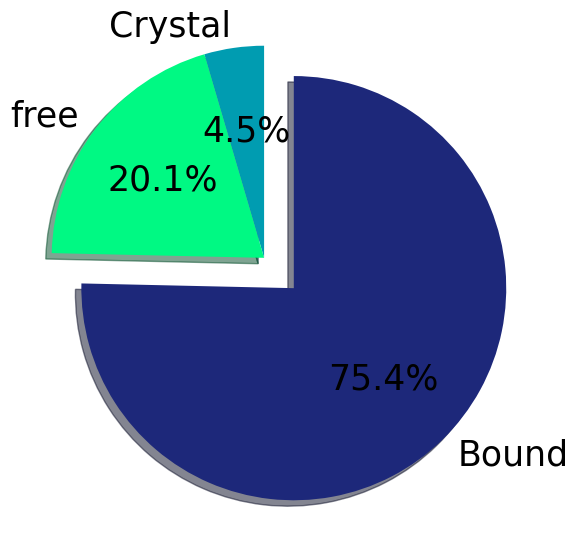

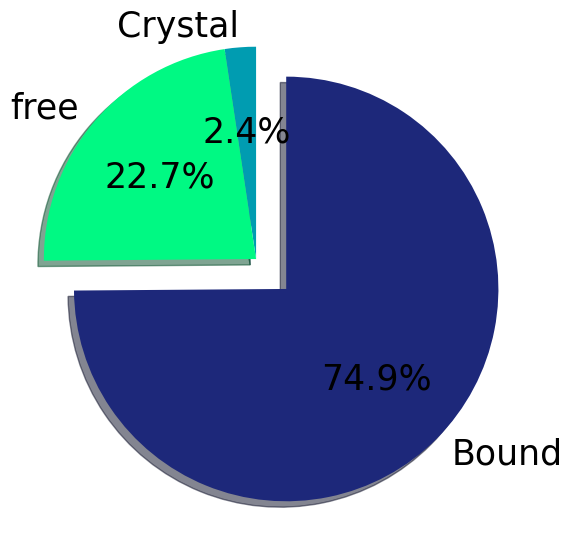

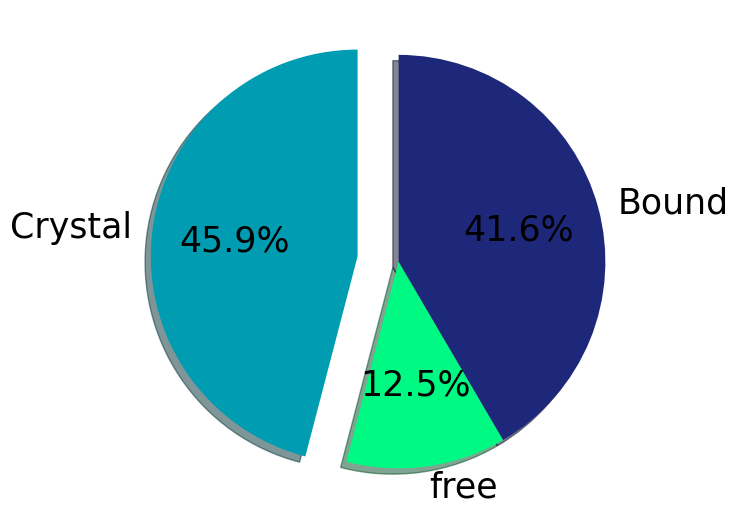

In [ ]:
#intesity fractions
df_common_filtered[['Intensity_'+purespecies0, 'Intensity_'+purespecies1, 'Intensity_'+purespecies2]] = df_common_filtered.apply(
    lambda row: Triangle_IntensityFractions(points1, points2,points3,[row['G'], row['S']],
                                            purespecies), axis=1, result_type='expand')
#conversion to molar fractions
df_common_filtered[['molar_'+purespecies0, 'molar_'+purespecies1, 'molar_'+purespecies2]] = df_common_filtered.apply(
    lambda row: molar_conversion([row['Intensity_'+purespecies0], row['Intensity_'+purespecies1],row['Intensity_'+purespecies2]],
                                            eps_list, QY_list), axis=1, result_type='expand')


In [ ]:
list(molar_fractions.values)

[0.011030654115266764, 0.9820162127094869, 0.006953133175246272]

In [ ]:
molar_df

,index,Sample,G,G std,S,S std,lifetime,lifetime std,sampled points,Contour PCA variability ratio,ContourIdx,phasor,days,Intensity_Crystal,Intensity_free,Intensity_Bound,molar_Crystal,molar_free,molar_Bound
39,0,Doxoves,0.756316,0.005132,0.258657,0.003713,1.495586,0.007258,260217,0.640258,39,1,0,0.459342,0.125035,0.415623,0.987993,0.006927,0.00508


## FIT ON PHASOR PLOT

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# List of items
items = df.Sample.to_list()

# Create the multiple selection widget
selection_widget = widgets.SelectMultiple(
    options=items,
    description='Select items:',
    rows=len(items)
)

# Create the button widget
button = widgets.Button(description='Confirm')

# Define a function to handle button click
def on_button_click(button):
    selected_items = selection_widget.value
    print("Selected items:", selected_items)

# Attach the button click event handler
button.on_click(on_button_click)

# Display the widgets
display(selection_widget, button)


In [ ]:
selection_widget.value

,index,Sample,G,G std,S,S std,lifetime,lifetime std,sampled points,Contour PCA variability ratio,ContourIdx,phasor,days
0,0,doxoves4,0.771758,0.00088,0.251034,0.000538,1.432264,0.001244,1856,0.704497,0,1,1
1,0,doxoves4,0.760966,0.000731,0.25734,0.00068,1.474983,0.001034,3674,0.694656,1,1,3
2,0,doxoves4,0.760758,0.00056,0.263971,0.000569,1.464876,0.000792,2558,0.726813,2,1,8
3,0,doxoves4,0.761448,0.000927,0.245359,0.000594,1.492064,0.001311,3650,0.702733,5,1,17
4,0,doxoves4,0.760763,0.000814,0.245395,0.000734,1.495383,0.001151,6007,0.704954,6,1,22
5,0,doxoves4,0.759705,0.001169,0.263443,0.000959,1.470922,0.001654,7536,0.722026,7,1,24
6,0,doxoves4,0.759602,0.001172,0.257192,0.000739,1.481917,0.001658,5789,0.733591,8,1,29
7,0,doxoves4,0.760397,0.000892,0.26375,0.000878,1.467018,0.001262,3248,0.613389,9,1,31
8,0,doxoves4,0.845522,0.000303,0.17922,0.00047,1.157705,0.000429,1638,0.791398,10,1,34
9,0,doxoves4,0.748774,0.000401,0.257132,0.00045,1.535166,0.000567,1766,0.706864,11,1,56
